# 신규 아파트 분양가격 동향

In [6]:
%ls "./data/apt_price"

 D 드라이브의 볼륨: Data
 볼륨 일련 번호: D818-A4B8

 d:\lec\04.python\data\apt_price 디렉터리

2023-11-09  오전 09:46    <DIR>          .
2023-11-09  오전 09:46    <DIR>          ..
2023-11-09  오전 09:45           171,938 전국 신규 민간 아파트 분양가격 동향_20200331.csv
2023-11-09  오전 09:45           105,382 전국_평균_분양가격_2018.6월_.csv
2023-11-09  오전 09:45           108,525 전국_평균_분양가격_2018.7월_.csv
2023-11-09  오전 09:45             4,528 지역별_3.3㎡당_평균_분양가격_천원__15.09월.csv
               4개 파일             390,373 바이트
               2개 디렉터리  781,439,336,448 바이트 남음


In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from plotnine import * # 시각화패키지
import folium          # 지도표현가능 패키지
import re

In [7]:
# 신규 아파트 분양가격 데이터 로딩
pre_sale = pd.read_csv('./data/apt_price/전국 신규 민간 아파트 분양가격 동향_20200331.csv'
                      , encoding="euc-kr", engine='python')
display(pre_sale.head())
display(pre_sale.tail())
print(pre_sale.shape)

,지역명,규모구분,연도,월,분양가격(㎡)
0,서울,전체,2015,10,5841
1,서울,전용면적 60㎡이하,2015,10,5652
2,서울,전용면적 60㎡초과 85㎡이하,2015,10,5882
3,서울,전용면적 85㎡초과 102㎡이하,2015,10,5721
4,서울,전용면적 102㎡초과,2015,10,5879


,지역명,규모구분,연도,월,분양가격(㎡)
4585,제주,전체,2020,3,3955
4586,제주,전용면적 60㎡이하,2020,3,4039
4587,제주,전용면적 60㎡초과 85㎡이하,2020,3,3962
4588,제주,전용면적 85㎡초과 102㎡이하,2020,3,NaN
4589,제주,전용면적 102㎡초과,2020,3,3601


(4590, 5)


In [13]:
# 1. 데이터현황분석
display(pre_sale.info())
display(pre_sale.dtypes)
display(pre_sale.isnull().sum())  # 결측치

# 결과분석
# 1. 분양가격이 숫자타입이 아니기 때문에 숫자타입으로 변환해야 한다.
# 2. 분양가격에 결측치가 305건이 존재한다. 결측치를 삭제(분석자결정사항)해야 한다.
# 3. 현재 index가 순번으로 되어 있기 때문에 년월별로 데이터분석을 위해서  연도,월을
#    인덱스로 지정해야 하고, 수치타입(int64)이 아니기 때문에 문자열(즉, 객체)로 변경해야 한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4590 entries, 0 to 4589
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   지역명      4590 non-null   object
 1   규모구분     4590 non-null   object
 2   연도       4590 non-null   int64 
 3   월        4590 non-null   int64 
 4   분양가격(㎡)  4285 non-null   object
dtypes: int64(2), object(3)
memory usage: 179.4+ KB


None

지역명        object
규모구분       object
연도          int64
월           int64
분양가격(㎡)    object
dtype: object

지역명          0
규모구분         0
연도           0
월            0
분양가격(㎡)    305
dtype: int64

In [14]:
# 결측치를 시각화 해주는 패키지
!pip install missingno
!pip show missingno

Defaulting to user installation because normal site-packages is not writeable
Name: missingno
Version: 0.5.2
Summary: Missing data visualization module for Python.
Home-page: https://github.com/ResidentMario/missingno
Author: Aleksey Bilogur
Author-email: aleksey.bilogur@gmail.com
License: MIT License
Location: C:\Users\gilbaek\AppData\Roaming\Python\Python311\site-packages
Requires: matplotlib, numpy, scipy, seaborn
Required-by: 


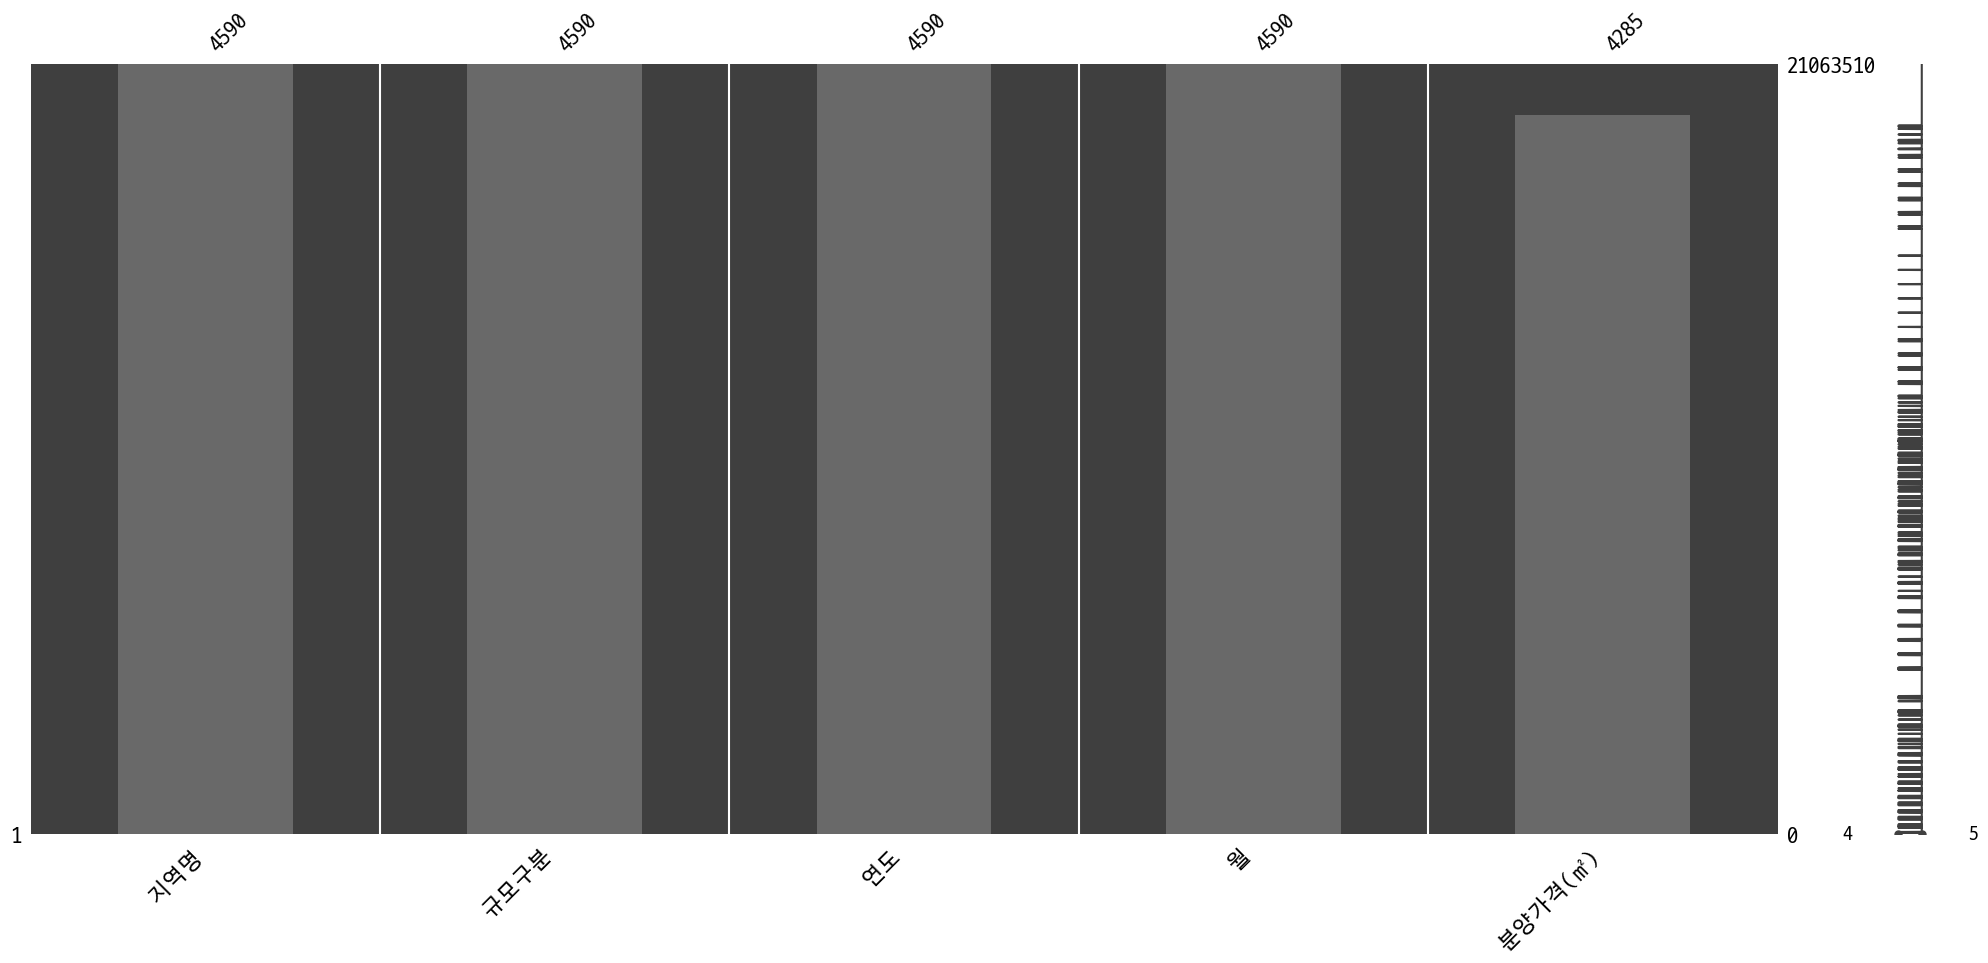

In [16]:
# 2. 결측치현황파악
import missingno as msno
msno.matrix(pre_sale, figsize=(10,6))
msno.bar(pre_sale)
plt.show()

In [17]:
# 3. 데이터정제(크린징)
# 1) 연도와 월을 인덱스 변환, 연도와 월은 수치형이기 때문에 문자열(분류형(범주형))로 변환
#    즉, int64에서 object로 형변환
pre_sale.연도 = pre_sale.연도.astype(str)
pre_sale.월 = pre_sale.월.astype(str)
pre_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4590 entries, 0 to 4589
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   지역명      4590 non-null   object
 1   규모구분     4590 non-null   object
 2   연도       4590 non-null   object
 3   월        4590 non-null   object
 4   분양가격(㎡)  4285 non-null   object
dtypes: object(5)
memory usage: 179.4+ KB


In [24]:
# 2) 분양가격의 자료형 즉, object를 수치형으로 변경 
#    to_numeric()함수를 사용
pre_sale_price = pre_sale['분양가격(㎡)']
display(pre_sale_price.info())

# pd.to_numeric?
# errors='coerce' -> If 'coerce', then invalid parsing will be set as NaN. 
# 즉, 에러발생시 강제로 NaN값으로 대체하는 옵션

pre_sale['분양가격'] = pd.to_numeric(pre_sale_price, errors='coerce')
display(pre_sale.info())

<class 'pandas.core.series.Series'>
RangeIndex: 4590 entries, 0 to 4589
Series name: 분양가격(㎡)
Non-Null Count  Dtype 
--------------  ----- 
4285 non-null   object
dtypes: object(1)
memory usage: 36.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4590 entries, 0 to 4589
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   지역명      4590 non-null   object 
 1   규모구분     4590 non-null   object 
 2   연도       4590 non-null   object 
 3   월        4590 non-null   object 
 4   분양가격(㎡)  4285 non-null   object 
 5   분양가격     4184 non-null   float64
dtypes: float64(1), object(5)
memory usage: 215.3+ KB


None

In [26]:
# 3) 평당분양가격
pre_sale['평당분양가격'] = pre_sale.분양가격 / 3.3
display(pre_sale.head())
display(pre_sale.tail())
pre_sale.info()

,지역명,규모구분,연도,월,분양가격(㎡),분양가격,평당분양가격
0,서울,전체,2015,10,5841,5841.0,1770.000000
1,서울,전용면적 60㎡이하,2015,10,5652,5652.0,1712.727273
2,서울,전용면적 60㎡초과 85㎡이하,2015,10,5882,5882.0,1782.424242
3,서울,전용면적 85㎡초과 102㎡이하,2015,10,5721,5721.0,1733.636364
4,서울,전용면적 102㎡초과,2015,10,5879,5879.0,1781.515152


,지역명,규모구분,연도,월,분양가격(㎡),분양가격,평당분양가격
4585,제주,전체,2020,3,3955,3955.0,1198.484848
4586,제주,전용면적 60㎡이하,2020,3,4039,4039.0,1223.939394
4587,제주,전용면적 60㎡초과 85㎡이하,2020,3,3962,3962.0,1200.606061
4588,제주,전용면적 85㎡초과 102㎡이하,2020,3,NaN,NaN,NaN
4589,제주,전용면적 102㎡초과,2020,3,3601,3601.0,1091.212121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4590 entries, 0 to 4589
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   지역명      4590 non-null   object 
 1   규모구분     4590 non-null   object 
 2   연도       4590 non-null   object 
 3   월        4590 non-null   object 
 4   분양가격(㎡)  4285 non-null   object 
 5   분양가격     4184 non-null   float64
 6   평당분양가격   4184 non-null   float64
dtypes: float64(2), object(5)
memory usage: 251.1+ KB


In [31]:
# 4) 결측치확인
pre_sale.isnull().sum()

지역명          0
규모구분         0
연도           0
월            0
분양가격(㎡)    305
분양가격       406
평당분양가격     406
dtype: int64

In [35]:
# 5) 데이터현황(2)
# describe()함수 - 기총통계량을 제공
# 기본이 수치자료만 제공, 수치자료이외의 기초정보를 조회할 경우 include옵션을 사용
display(pre_sale.describe())
display(pre_sale.describe(include=[np.object_]))

,분양가격,평당분양가격
count,4184.000000,4184.000000
mean,3271.654876,991.410568
std,1302.987924,394.844825
min,1868.000000,566.060606
25%,2457.500000,744.696970
50%,2894.000000,876.969697
75%,3601.250000,1091.287879
max,13835.000000,4192.424242


,지역명,규모구분,연도,월,분양가격(㎡)
count,4590,4590,4590,4590,4285
unique,17,5,6,12,1813
top,서울,전체,2016,10,3395
freq,270,918,1020,425,18


In [38]:
# 2019년도 데이터만 추출 - loc함수이용
pre_sale_2019 = pre_sale.loc[pre_sale.연도 == '2019']
pre_sale_2019.head()

,지역명,규모구분,연도,월,분양가격(㎡),분양가격,평당분양가격
3315,서울,전체,2019,1,7600,7600.0,2303.030303
3316,서울,전용면적 60㎡이하,2019,1,7400,7400.0,2242.424242
3317,서울,전용면적 60㎡초과 85㎡이하,2019,1,8105,8105.0,2456.060606
3318,서울,전용면적 85㎡초과 102㎡이하,2019,1,6842,6842.0,2073.333333
3319,서울,전용면적 102㎡초과,2019,1,7787,7787.0,2359.696970


In [42]:
# 규모구분 즉, 평형별 데이터 건수는?
print(pre_sale.규모구분.value_counts())
print()

# 지역별 데이터 건수?
print(pre_sale.지역명.value_counts())

규모구분
전체                   918
전용면적 60㎡이하           918
전용면적 60㎡초과 85㎡이하     918
전용면적 85㎡초과 102㎡이하    918
전용면적 102㎡초과          918
Name: count, dtype: int64

지역명
서울    270
강원    270
경남    270
경북    270
전남    270
전북    270
충남    270
충북    270
세종    270
인천    270
울산    270
대전    270
광주    270
대구    270
부산    270
경기    270
제주    270
Name: count, dtype: int64


###### 실습 A. 전국평균분양가격 및 규모별 평균분양가격

<img src="./images/26.데이터분석_실습03.전국 신규아파트 분양가격 동향_실습01. 전국평균분양가가격.PNG" width="250" height="150">
<img src="./images/26.데이터분석_실습03.전국 신규아파트 분양가격 동향_실습02. 규모별전국평균분양가가격.PNG" width="250" height="150">

In [49]:
# 실습01. 전국평균분양가격
# groupby, pivot(T)를 활용
# pre_sale, groupby(), describe(), T을 활용
pre_sale.groupby(pre_sale.연도).describe().T

연도                   2015         2016         2017         2018  \
분양가격   count   243.000000   984.000000   899.000000   919.000000   
       mean   2788.707819  2934.250000  3139.541713  3326.951034   
       std     976.861182  1071.441561  1107.584870  1186.090839   
       min    1868.000000  1900.000000  1976.000000  2076.000000   
       25%    2225.000000  2282.000000  2365.000000  2525.000000   
       50%    2516.000000  2672.000000  2849.000000  2952.000000   
       75%    3025.500000  3148.500000  3456.000000  3698.000000   
       max    7092.000000  8096.000000  7887.000000  8098.000000   
평당분양가격 count   243.000000   984.000000   899.000000   919.000000   
       mean    845.062975   889.166667   951.376277  1008.166980   
       std     296.018540   324.679261   335.631779   359.421466   
       min     566.060606   575.757576   598.787879   629.090909   
       25%     674.242424   691.515152   716.666667   765.151515   
       50%     762.424242   809.696970   863.333333   894.545455   
       75%     916.818182   954.090909  1047.272727  1120.606061   
       max    2149.090909  2453.333333  2390.000000  2453.939394   

연도                    2019          2020  
분양가격   count    912.000000    227.000000  
       mean    3693.422149   3856.074890  
       std     1563.205566   1755.193638  
       min     2124.000000   2297.000000  
       25%     2635.500000   2667.000000  
       50%     3395.000000   3534.000000  
       75%     4066.250000   4275.500000  
       max    12728.000000  13835.000000  
평당분양가격 count    912.000000    227.000000  
       mean    1119.218833   1168.507542  
       std      473.698656    531.876860  
       min      643.636364    696.060606  
       25%      798.636364    808.181818  
       50%     1028.787879   1070.909091  
       75%     1232.196970   1295.606061  
       max     3856.969697   4192.424242

In [51]:
pd.options.display.float_format = '{:,.2f}'.format # 현재 session동안 pandas의 옵션을 적용된다.
pre_sale.groupby(pre_sale.연도).describe().T

연도               2015     2016     2017     2018      2019      2020
분양가격   count   243.00   984.00   899.00   919.00    912.00    227.00
       mean  2,788.71 2,934.25 3,139.54 3,326.95  3,693.42  3,856.07
       std     976.86 1,071.44 1,107.58 1,186.09  1,563.21  1,755.19
       min   1,868.00 1,900.00 1,976.00 2,076.00  2,124.00  2,297.00
       25%   2,225.00 2,282.00 2,365.00 2,525.00  2,635.50  2,667.00
       50%   2,516.00 2,672.00 2,849.00 2,952.00  3,395.00  3,534.00
       75%   3,025.50 3,148.50 3,456.00 3,698.00  4,066.25  4,275.50
       max   7,092.00 8,096.00 7,887.00 8,098.00 12,728.00 13,835.00
평당분양가격 count   243.00   984.00   899.00   919.00    912.00    227.00
       mean    845.06   889.17   951.38 1,008.17  1,119.22  1,168.51
       std     296.02   324.68   335.63   359.42    473.70    531.88
       min     566.06   575.76   598.79   629.09    643.64    696.06
       25%     674.24   691.52   716.67   765.15    798.64    808.18
       50%     762.42   809.70   863.33   894.55  1,028.79  1,070.91
       75%     916.82   954.09 1,047.27 1,120.61  1,232.20  1,295.61
       max   2,149.09 2,453.33 2,390.00 2,453.94  3,856.97  4,192.42

In [54]:
# 실습02. 규모별 전국평균분양가격
# 1) 규모구분, 연도, 평당분양가격만 선택
# 2) T = pivot_table()와 동일
pre_sale[['규모구분', '연도', '평당분양가격']]
pre_sale.pivot_table('평당분양가격', '규모구분', '연도')

연도,2015,2016,2017,2018,2019,2020
규모구분,,,,,,
전용면적 102㎡초과,903.33,953.97,"1,040.82","1,051.02","1,224.20","1,271.85"
전용면적 60㎡이하,821.99,863.07,940.88,995.81,"1,056.64","1,098.94"
전용면적 60㎡초과 85㎡이하,816.51,853.63,902.20,978.02,"1,072.29","1,088.82"
전용면적 85㎡초과 102㎡이하,874.06,929.51,967.90,"1,050.66","1,191.98","1,375.08"
전체,816.63,853.36,909.21,980.33,"1,065.45","1,090.85"


In [59]:
# 실습03. 전국 아파트 분양가 변동금액
# 규모구분이 '전체'자료만 선택해서 연도별 변동금액에 대한 데이터 분석
region_year_all = pre_sale.loc[pre_sale.규모구분 == '전체']
region_year_all.head()

region_year = region_year_all.pivot_table('평당분양가격', '지역명', '연도')
print(type(region_year))
region_year.head()

<class 'pandas.core.frame.DataFrame'>


연도,2015,2016,2017,2018,2019,2020
지역명,,,,,,
강원,657.47,643.81,654.44,705.30,747.63,755.35
경기,952.93,"1,030.30","1,088.15","1,210.83","1,328.64","1,361.72"
경남,696.57,720.66,745.62,828.23,906.41,918.59
경북,658.48,675.91,715.79,781.01,813.28,826.67
광주,739.39,817.15,869.01,905.03,"1,085.66","1,164.55"


In [67]:
# 2015 vs 2020 변동액을 산출해서 결과를 '변동액'열을 추가
region_year['변동액'] = (region_year['2020'] - region_year['2015']).astype(np.int_)
display(region_year)

max_price = np.max(region_year.변동액) * 1000
min_price = np.min(region_year.변동액) * 1000
mean_price = np.round(np.mean(region_year.변동액) * 1000, 2)
print(min_price, max_price, mean_price)

연도,2015,2016,2017,2018,2019,2020,변동액
지역명,,,,,,,
강원,657.47,643.81,654.44,705.30,747.63,755.35,97
경기,952.93,"1,030.30","1,088.15","1,210.83","1,328.64","1,361.72",408
경남,696.57,720.66,745.62,828.23,906.41,918.59,222
경북,658.48,675.91,715.79,781.01,813.28,826.67,168
광주,739.39,817.15,869.01,905.03,"1,085.66","1,164.55",425
대구,847.78,946.74,"1,051.96","1,108.89","1,271.99","1,347.27",499
대전,743.64,780.68,830.55,934.82,"1,081.52","1,077.37",333
부산,946.46,957.75,"1,063.17","1,193.56","1,204.44","1,187.68",241
서울,"1,811.31","1,897.47","1,962.89","2,101.87","2,399.55","2,436.57",625


29000 625000 273764.71


In [76]:
# 결과분석
print('------------- [ 전국 신규아파트 분양가격 변동현황 결과 분석 ] -----------------')
print('1. 2015~2020.3월까지 분양가는 계속 상승하고 있으며 상승액 가장 큰 지역은 ' + 
      '서울이다. 서울의 상승액은 평당 {:,.0f}원이다'.format(max_price))
print('2. 상승액이 가장 낮은 지역은 울산이며 평당 {:,.0f}원이다'.format(min_price))
print('3. 하지만 울산지역의 데이터는 결측치가 많다. 따라서 변동액이 가장 작다고 판단할 경우 왜곡이 될 수 있다.')
print('4. 전국 분양가 평균변동액은 평당 {:,.0f}원이다'.format(mean_price))


------------- [ 전국 신규아파트 분양가격 변동현황 결과 분석 ] -----------------
1. 2015~2020.3월까지 분양가는 계속 상승하고 있으며 상승액 가장 큰 지역은 서울이다. 서울의 상승액은 평당 625,000원이다
2. 상승액이 가장 낮은 지역은 울산이며 평당 29,000원이다
3. 하지만 울산지역의 데이터는 결측치가 많다. 따라서 변동액이 가장 작다고 판단할 경우 왜곡이 될 수 있다.
4. 전국 분양가 평균변동액은 평당 273,765원이다


In [77]:
# 울산지역 데이터현황 분석
print(pre_sale.loc[pre_sale.지역명 == '울산'].info())
print(pre_sale.loc[pre_sale.지역명 == '울산'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 35 to 4544
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   지역명      270 non-null    object 
 1   규모구분     270 non-null    object 
 2   연도       270 non-null    object 
 3   월        270 non-null    object 
 4   분양가격(㎡)  167 non-null    object 
 5   분양가격     158 non-null    float64
 6   평당분양가격   158 non-null    float64
dtypes: float64(2), object(5)
memory usage: 16.9+ KB
None
지역명          0
규모구분         0
연도           0
월            0
분양가격(㎡)    103
분양가격       112
평당분양가격     112
dtype: int64


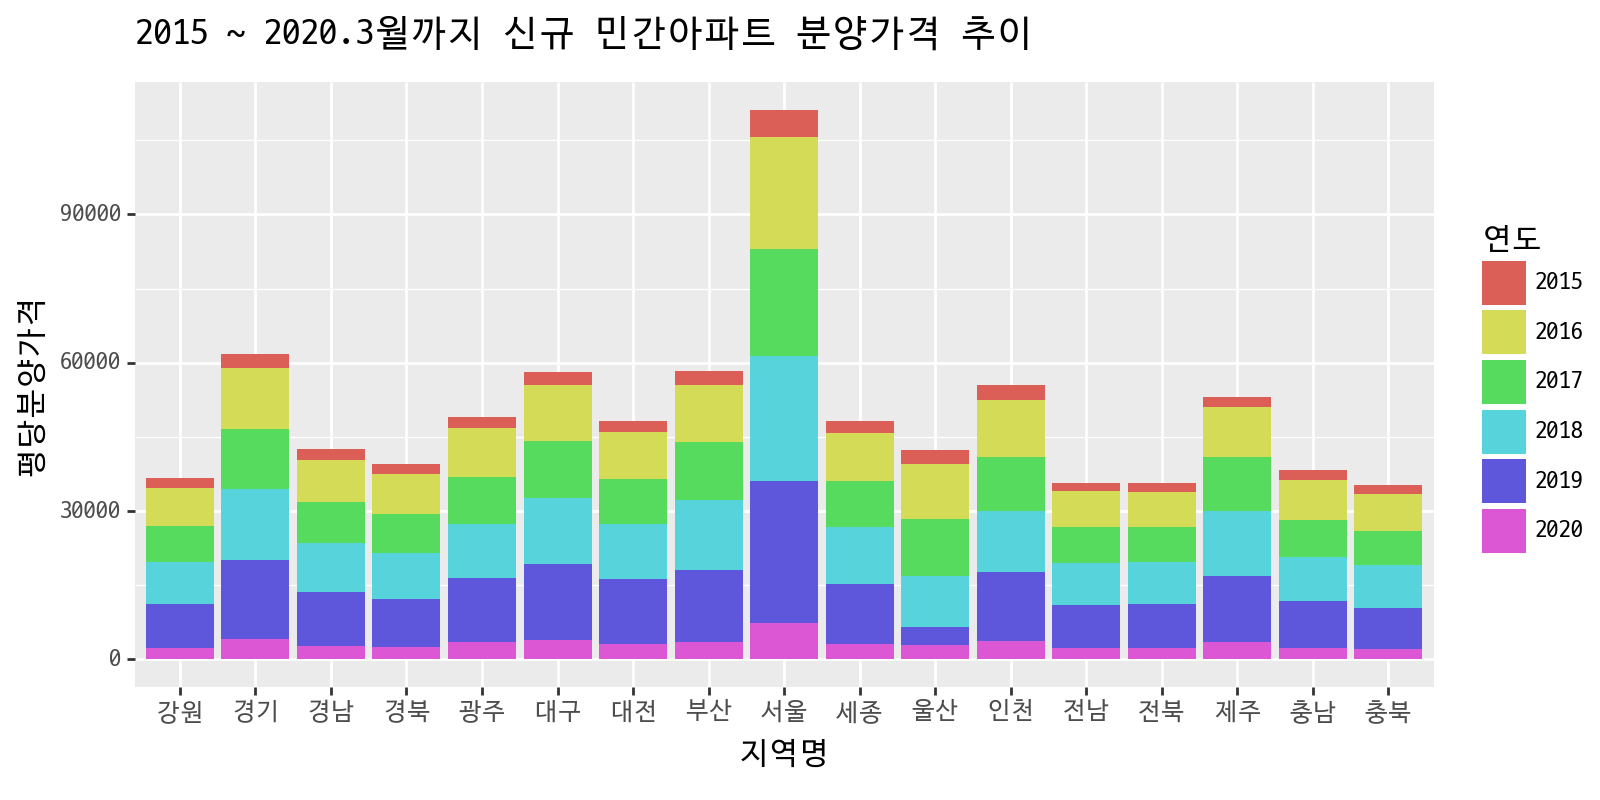

<Figure Size: (800 x 400)>

In [90]:
# 실습04. 분양가격의 시각화
# ggplot, regin_year_all, geom_bar
(ggplot(region_year_all)
 + aes(x='지역명', y='평당분양가격', fill='연도')
 + geom_bar(stat='identity') # , position='dodge')
 + ggtitle('2015 ~ 2020.3월까지 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        ,figure_size=(8,4))
)

In [92]:
# 실습05. 지역별 평당 분양가격
pre_sale.head()
pre_sale.pivot_table('평당분양가격', '규모구분', '지역명')

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
규모구분,,,,,,,,,,,,,,,,,
전용면적 102㎡초과,786.92,"1,368.19",951.18,844.57,"1,035.83","1,221.52","1,365.94","1,218.36","2,184.65",942.99,915.93,"1,328.98",763.65,755.55,973.78,801.43,754.67
전용면적 60㎡이하,699.20,"1,232.33",800.52,727.14,886.22,"1,112.71",857.22,"1,047.95","2,154.17",856.19,862.35,"1,042.65",668.91,702.57,"1,282.96",726.28,656.30
전용면적 60㎡초과 85㎡이하,690.80,"1,160.28",798.67,745.00,924.79,"1,096.61",901.49,"1,095.39","2,113.72",905.08,963.00,"1,056.97",672.97,672.08,988.08,722.63,669.75
전용면적 85㎡초과 102㎡이하,812.78,"1,278.26",923.52,805.68,853.64,"1,036.88",829.88,"1,121.33","2,478.48",913.33,813.68,"1,066.66",730.01,764.51,983.39,846.72,772.12
전체,690.53,"1,165.11",802.09,746.63,923.87,"1,096.00",908.74,"1,101.25","2,096.64",908.75,962.76,"1,045.80",674.24,674.09,"1,002.14",721.93,665.97


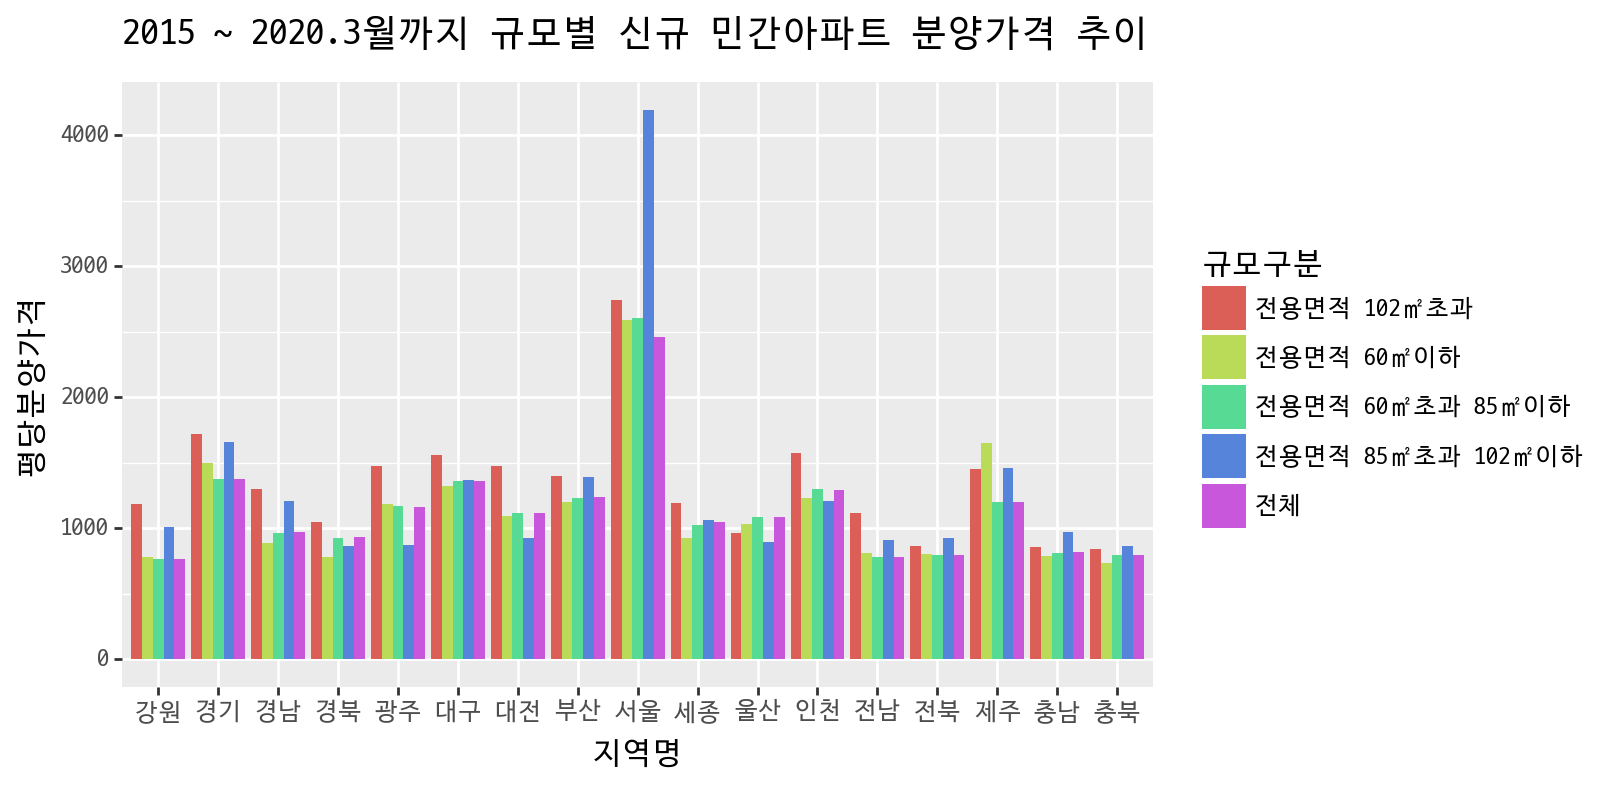

<Figure Size: (800 x 400)>

In [96]:
# 실습06. 규모별 신규 민간아파트 분양가격 시각화
# ggplot, pre_sale
(ggplot(pre_sale)
 + aes(x='지역명', y='평당분양가격', fill='규모구분')
 + geom_bar(stat='identity', position='dodge')
 + ggtitle('2015 ~ 2020.3월까지 규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        ,figure_size=(8,4))
)

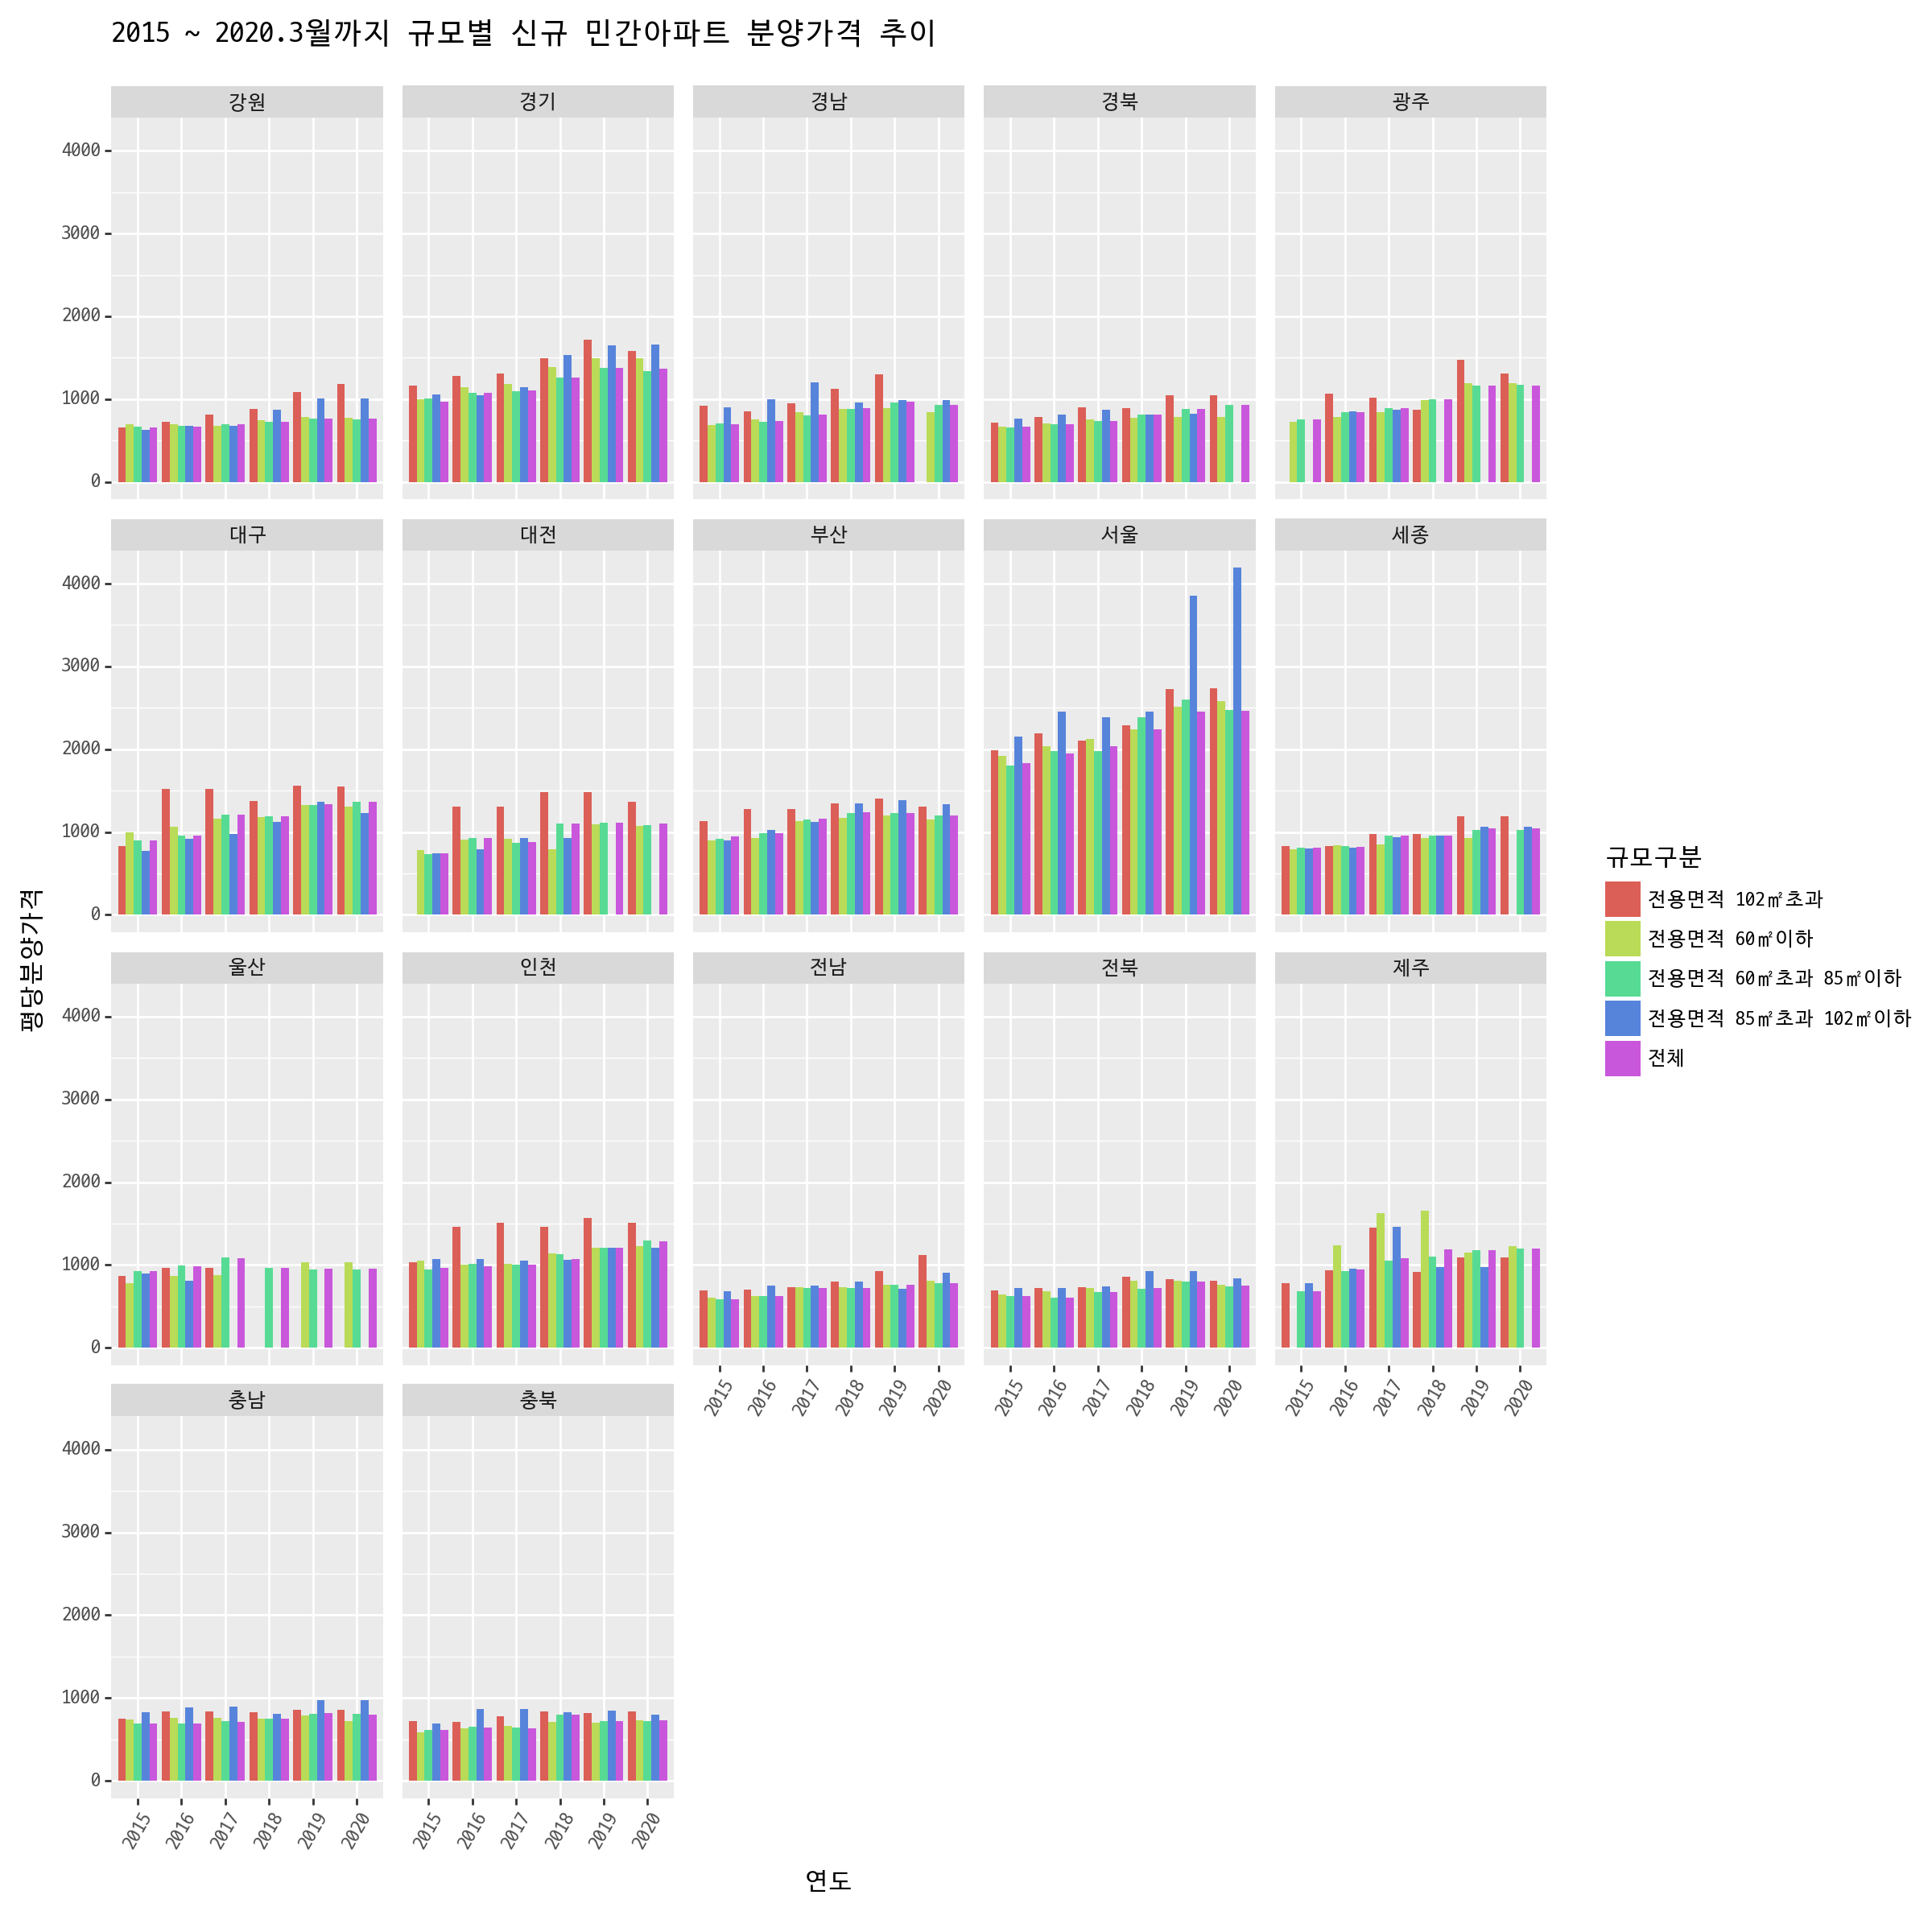

<Figure Size: (1200 x 1200)>

In [103]:
# 실습07. 지역별로 matrix형태로 시각화
(ggplot(pre_sale)
 + aes(x='연도', y='평당분양가격', fill='규모구분')
 + geom_bar(stat='identity', position='dodge')
 + ggtitle('2015 ~ 2020.3월까지 규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        , figure_size=(12,12)
        , axis_text_x=element_text(rotation=60))
 + facet_wrap('지역명')
)

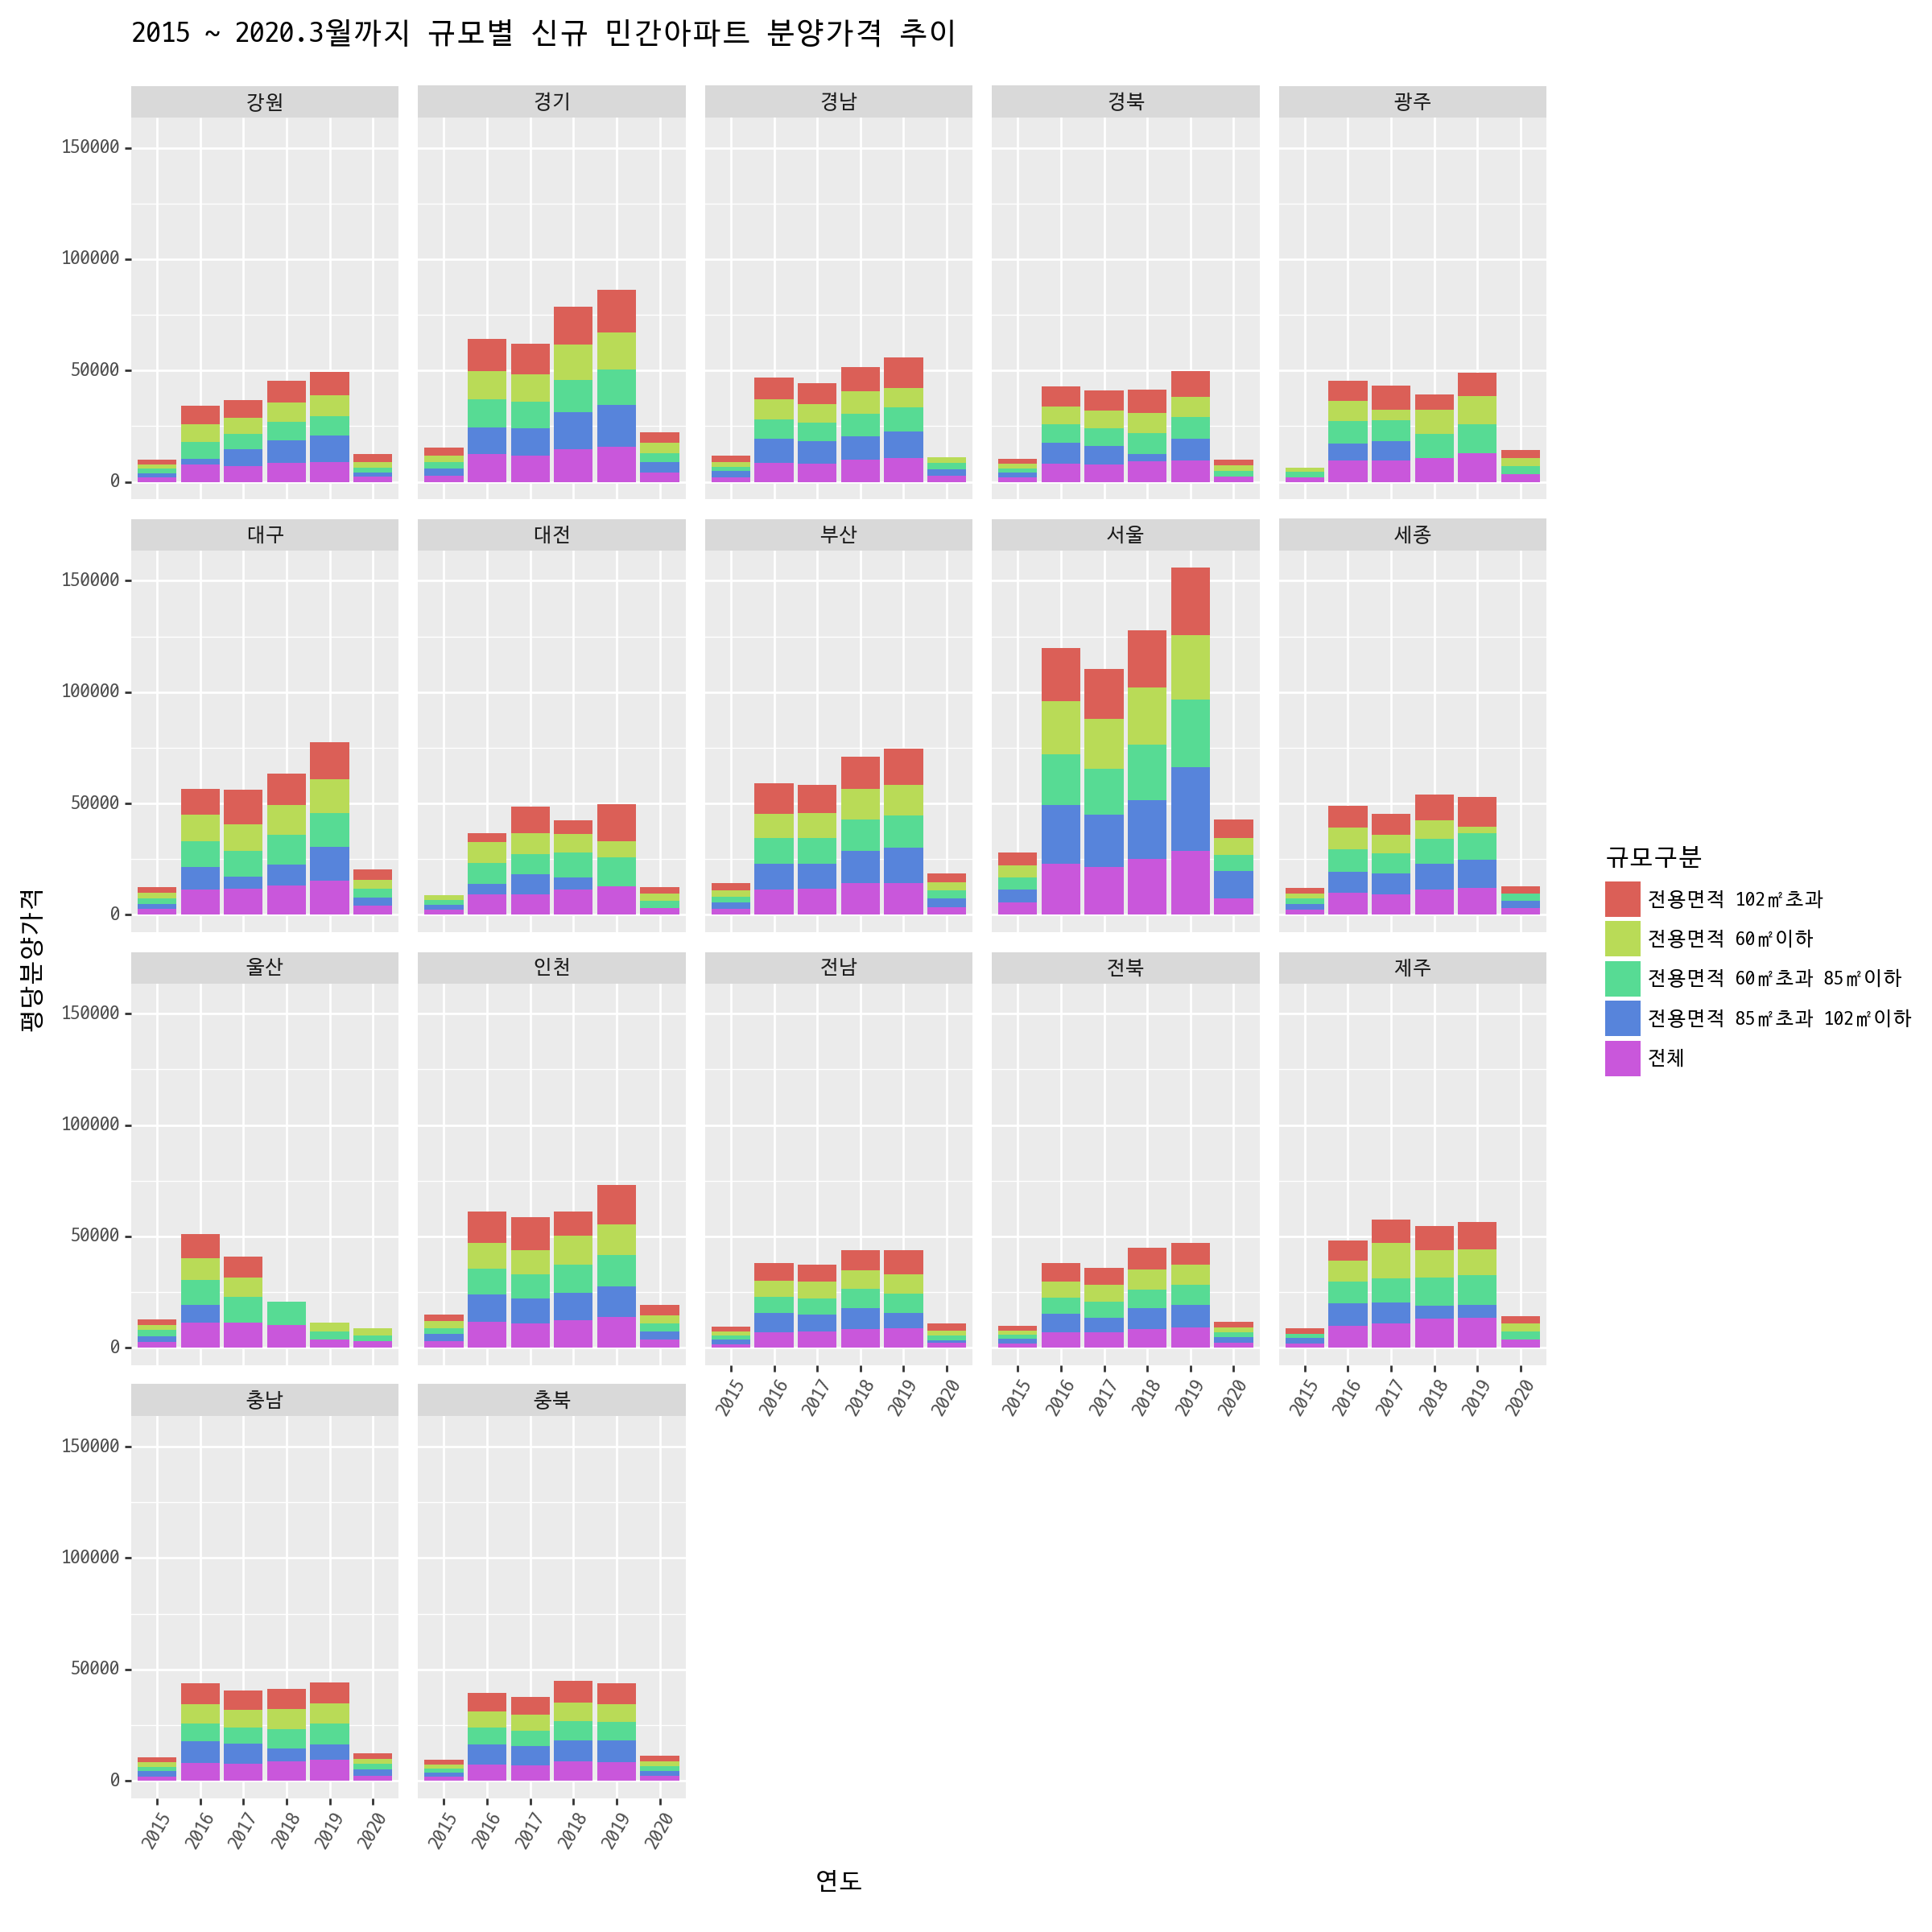

<Figure Size: (1200 x 1200)>

In [104]:
(ggplot(pre_sale)
 + aes(x='연도', y='평당분양가격', fill='규모구분')
 + geom_bar(stat='identity')
 + ggtitle('2015 ~ 2020.3월까지 규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        , figure_size=(12,12)
        , axis_text_x=element_text(rotation=60))
 + facet_wrap('지역명')
)

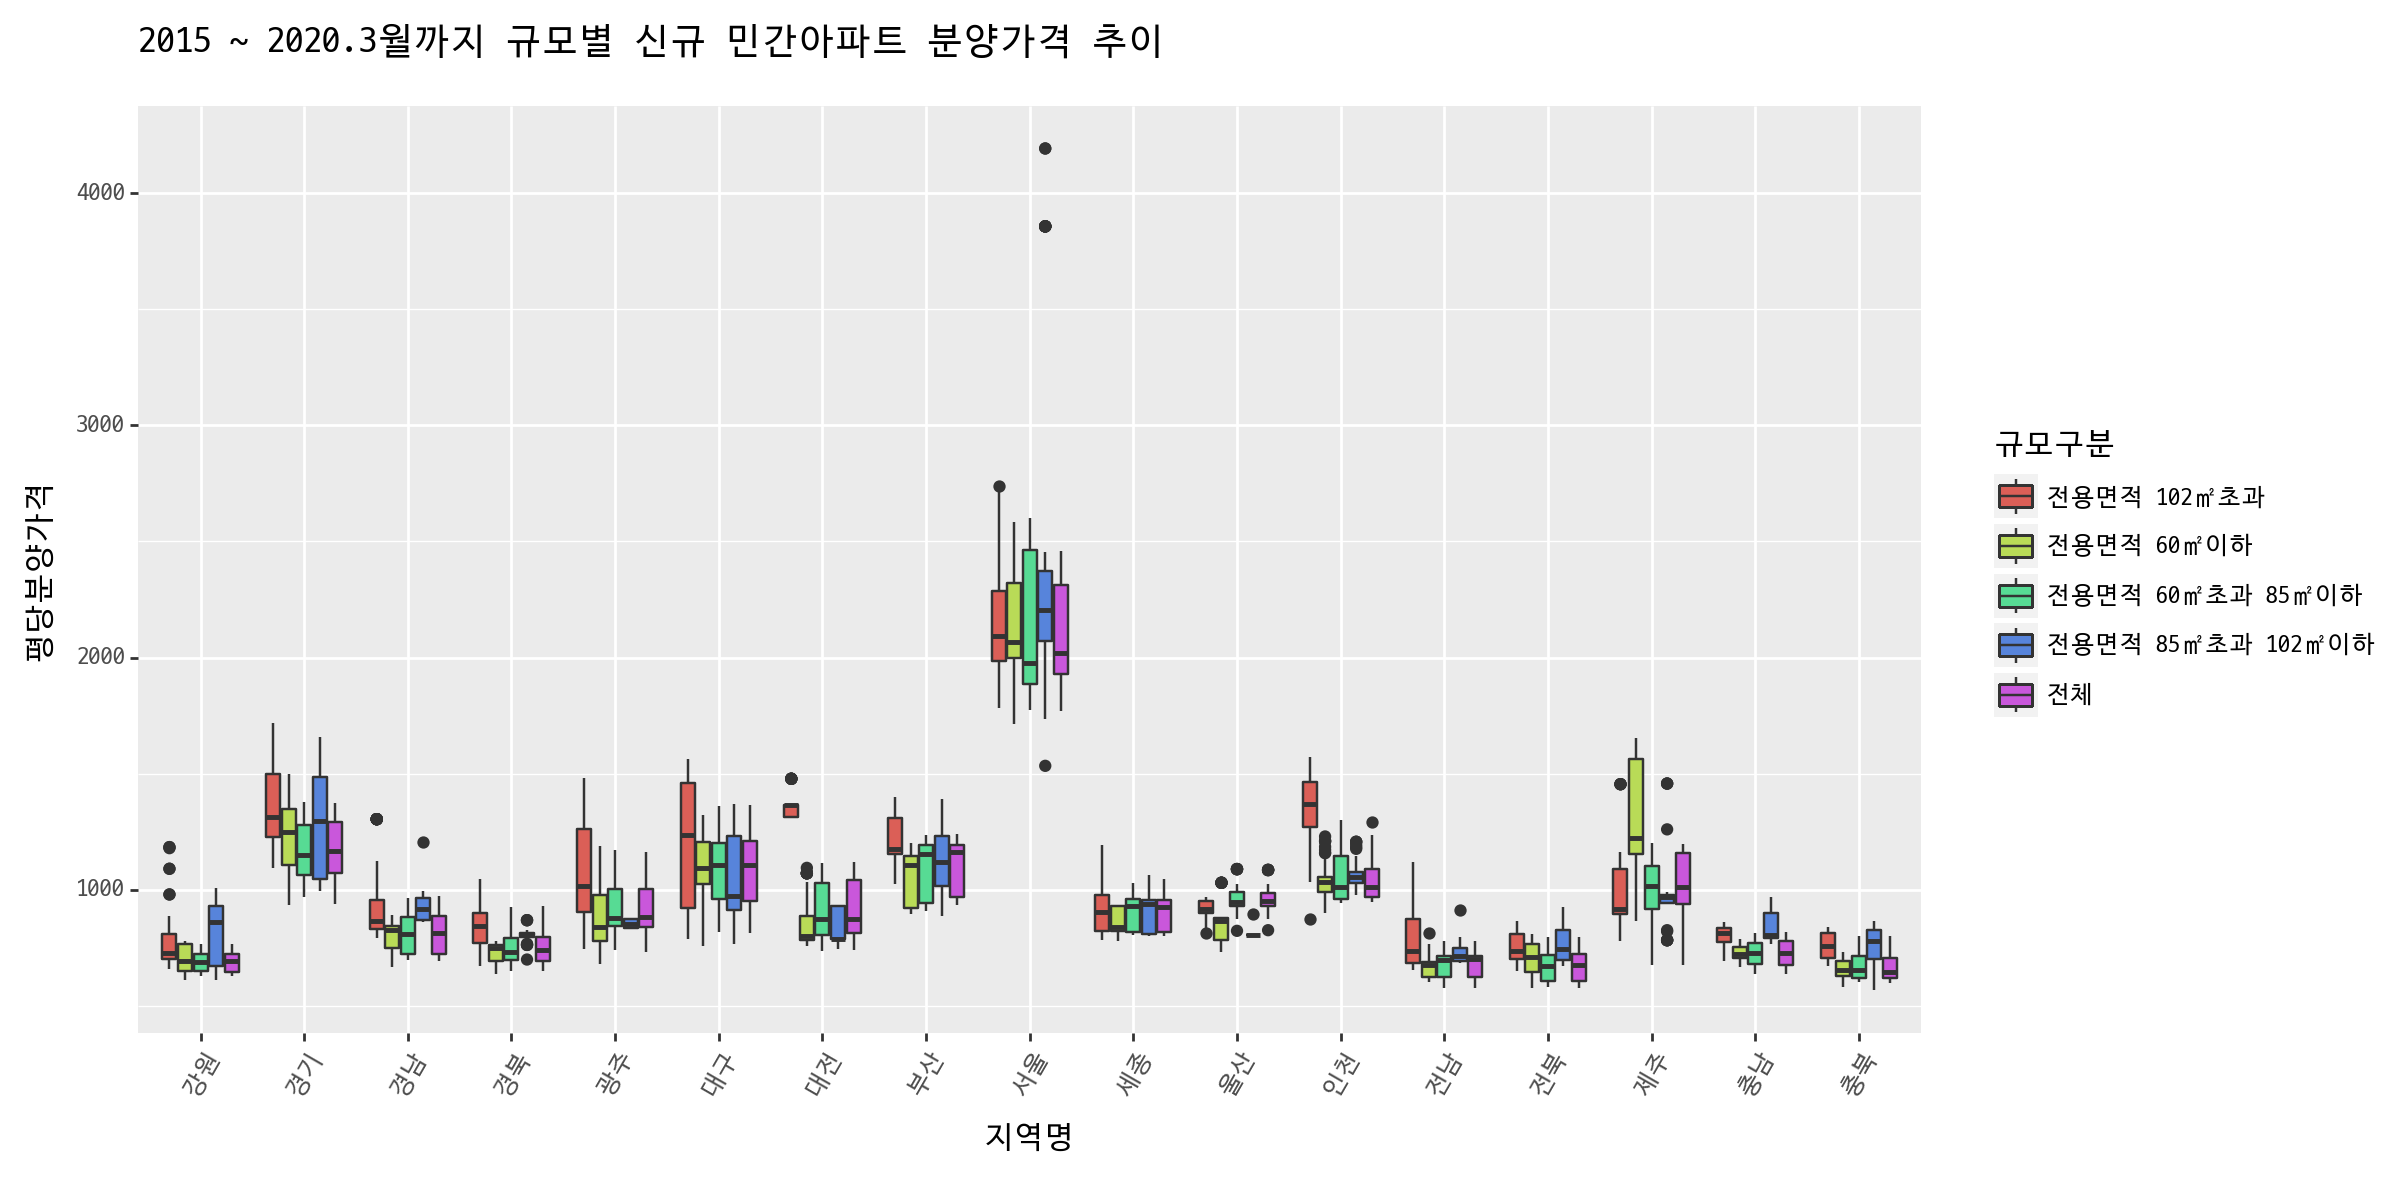

<Figure Size: (1200 x 600)>

In [109]:
# 실습08. 지역별/규모구분 box-plot으로 시각화
# geom_boxplot()
(ggplot(pre_sale)
 + aes(x='지역명', y='평당분양가격', fill='규모구분')
 + geom_boxplot()
 + ggtitle('2015 ~ 2020.3월까지 규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        , figure_size=(12,6)
        , axis_text_x=element_text(rotation=60))
)

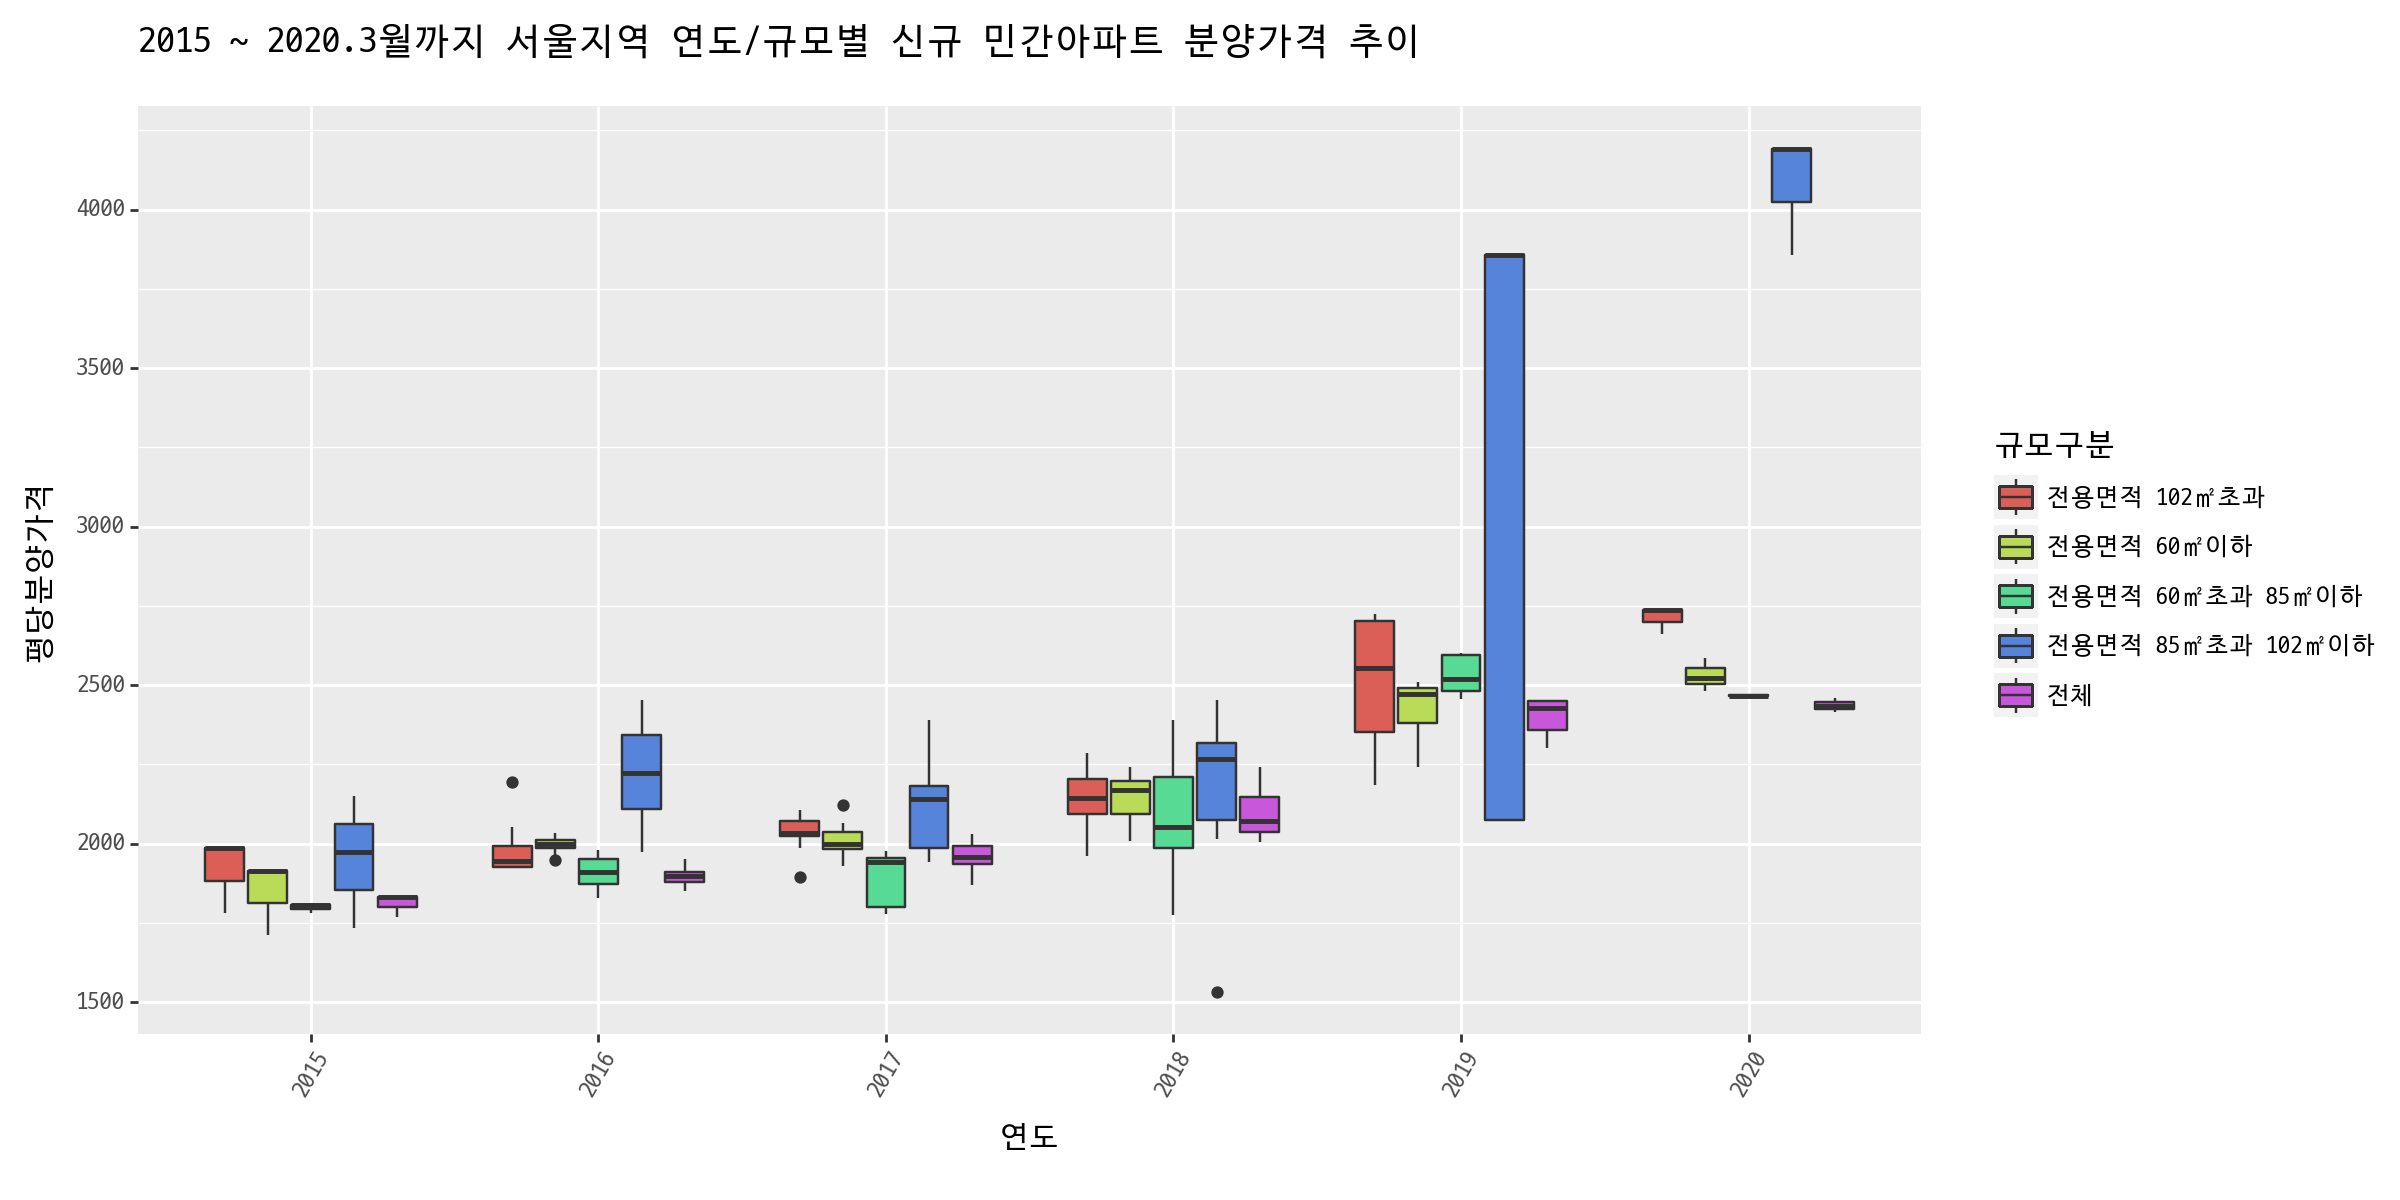

<Figure Size: (1200 x 600)>

In [110]:
# 실습08. 서울지역, 연도별/규모구분 box-plot으로 시각화
# 서울데이터만 추출
pre_sale_seoul = pre_sale.loc[pre_sale.지역명 == '서울']

(ggplot(pre_sale_seoul)
 + aes(x='연도', y='평당분양가격', fill='규모구분')
 + geom_boxplot()
 + ggtitle('2015 ~ 2020.3월까지 서울지역 연도/규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        , figure_size=(12,6)
        , axis_text_x=element_text(rotation=60))
)

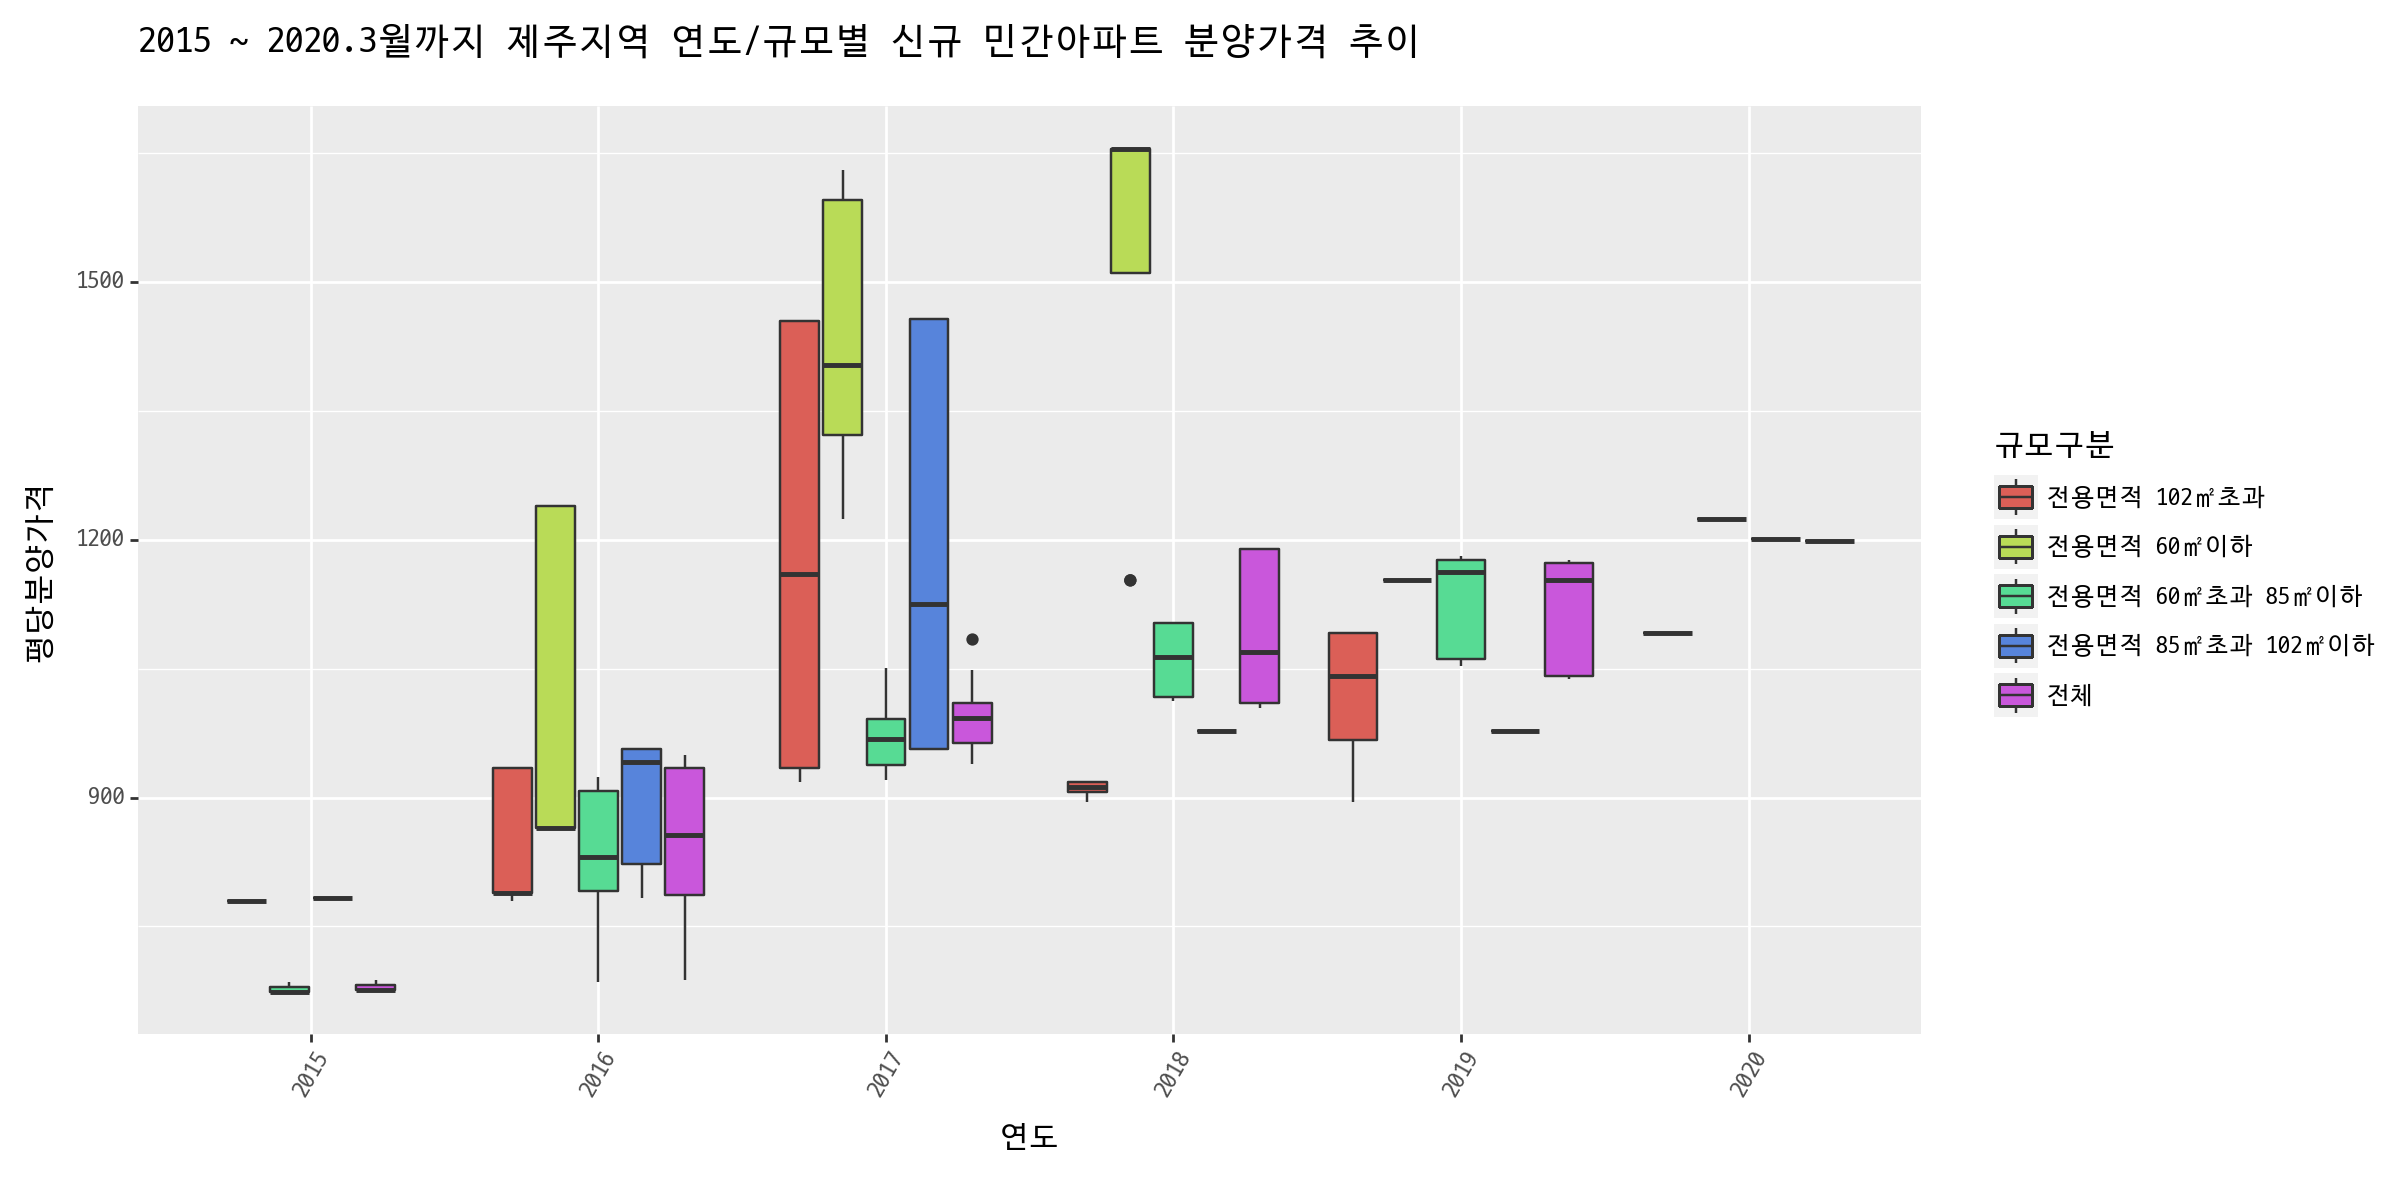

<Figure Size: (1200 x 600)>

In [111]:
# 제주지역
(ggplot(pre_sale.loc[pre_sale.지역명 == '제주'])
 + aes(x='연도', y='평당분양가격', fill='규모구분')
 + geom_boxplot()
 + ggtitle('2015 ~ 2020.3월까지 제주지역 연도/규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        , figure_size=(12,6)
        , axis_text_x=element_text(rotation=60))
)

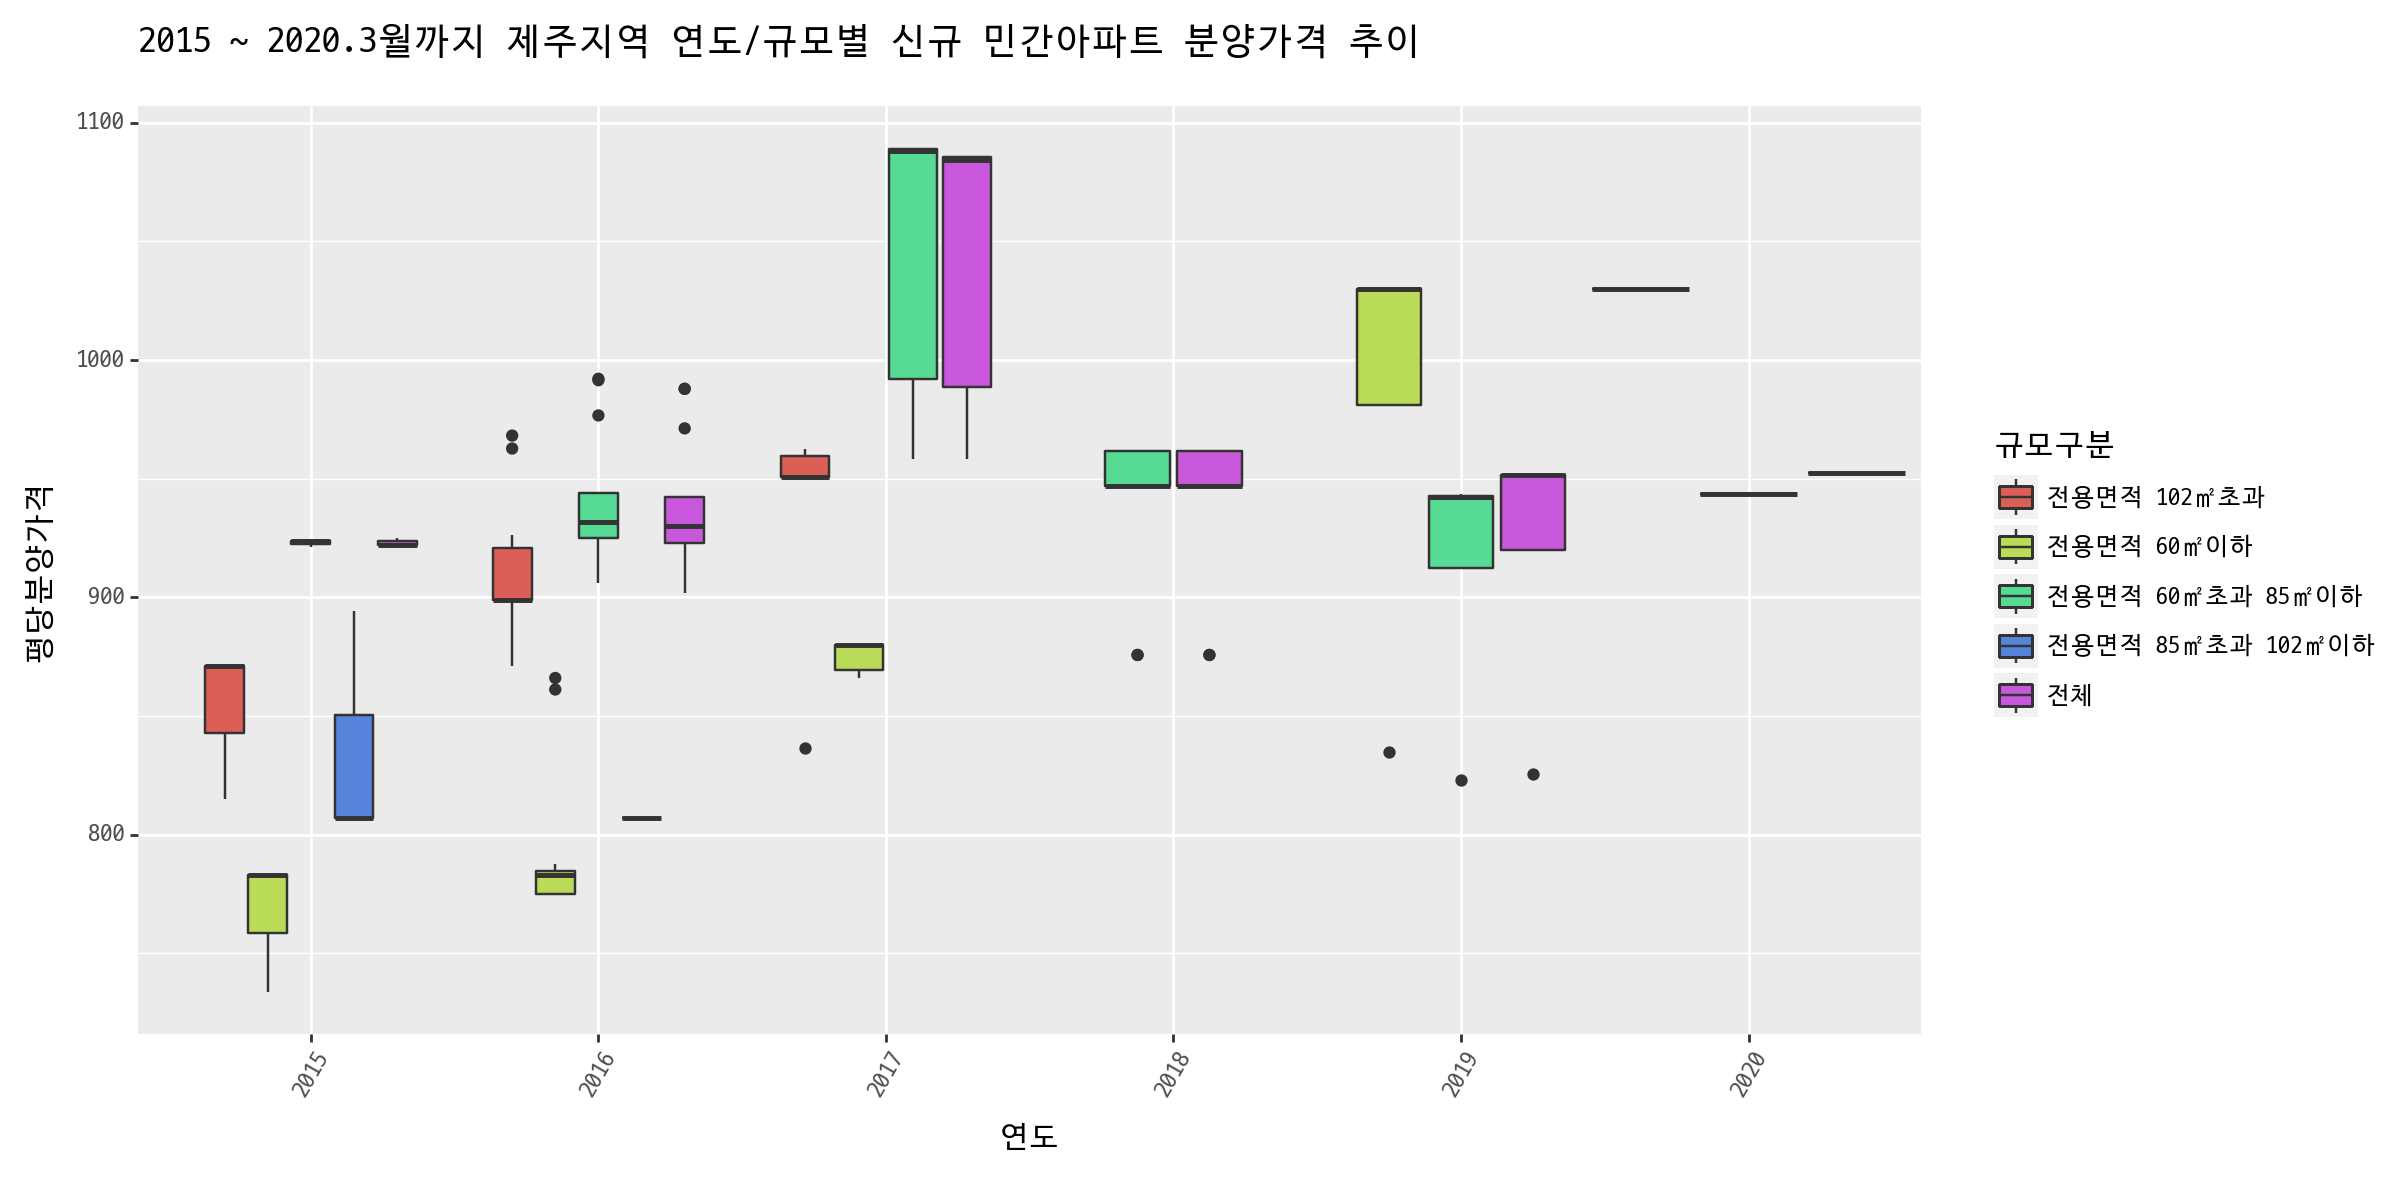

<Figure Size: (1200 x 600)>

In [112]:
# 울산지역
(ggplot(pre_sale.loc[pre_sale.지역명 == '울산'])
 + aes(x='연도', y='평당분양가격', fill='규모구분')
 + geom_boxplot()
 + ggtitle('2015 ~ 2020.3월까지 제주지역 연도/규모별 신규 민간아파트 분양가격 추이')
 + theme(text=element_text(family='D2Coding')
        , figure_size=(12,6)
        , axis_text_x=element_text(rotation=60))
)

###### 지역별 3.3m2당 평균 분양가격(천단위) 2015.9월까지
* 파일다운로드 : https://www.data.go.kr/data/15058820/openapi.do API요청
* 지역별_3.3㎡당_평균_분양가격_천원__15.09월.csv

In [121]:
df = pd.read_csv('./data/apt_price/지역별_3.3㎡당_평균_분양가격_천원__15.09월.csv'
                , encoding='euc-kr', engine='python', skiprows=1, header=0)
display(df.head())
df.shape

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,구분,NaN,2013년,2014년,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(단위: 천원/3.3㎡)
1,시도,시군구,12월,1월,2월,3월,4월,5월,6월,7월,...,3월,4월,5월,6월,7월,8월,9월,전월비,전년말비,전년동월비
2,전국,NaN,"8,059","8,130","8,195","8,204","8,289","8,358","8,344","8,333",...,"8,563","8,613","8,624","8,627","8,643","8,678","8,665",-13,82,207
3,서울,NaN,"18,189","17,925","17,925","18,016","18,098","19,446","18,867","18,742",...,"19,415","18,842","18,367","18,374","18,152","18,443","17,969",-474,"-2,300","-1,434"
4,6대광역시,부산,"8,111","8,111","9,078","8,965","9,402","9,501","9,453","9,457",...,"9,279","9,327","9,345","9,515","9,559","9,581","9,608",1,430,477


(23, 27)

In [122]:
# 실습01. 데이터정제
year = df.iloc[0]
month = df.iloc[1]
print(year)
print(month)

Unnamed: 0                구분
Unnamed: 1               NaN
Unnamed: 2             2013년
Unnamed: 3             2014년
Unnamed: 4               NaN
Unnamed: 5               NaN
Unnamed: 6               NaN
Unnamed: 7               NaN
Unnamed: 8               NaN
Unnamed: 9               NaN
Unnamed: 10              NaN
Unnamed: 11              NaN
Unnamed: 12              NaN
Unnamed: 13              NaN
Unnamed: 14              NaN
Unnamed: 15            2015년
Unnamed: 16              NaN
Unnamed: 17              NaN
Unnamed: 18              NaN
Unnamed: 19              NaN
Unnamed: 20              NaN
Unnamed: 21              NaN
Unnamed: 22              NaN
Unnamed: 23              NaN
Unnamed: 24              NaN
Unnamed: 25              NaN
Unnamed: 26    (단위: 천원/3.3㎡)
Name: 0, dtype: object
Unnamed: 0        시도
Unnamed: 1       시군구
Unnamed: 2       12월
Unnamed: 3        1월
Unnamed: 4        2월
Unnamed: 5        3월
Unnamed: 6        4월
Unnamed: 7        5월
Unnamed: 8        6월
Unnam

In [123]:
# 1) 컬럼을 새로 만들기 위해 0번째 행(년)과, 1번째행(월)을 합치기
for i, y in enumerate(year):
    # print(i, '-', y)
    if i > 2 and i < 15:
        year[i] = ' '.join(['2014년', month[i]])
    elif i >= 15:
        year[i] = ' '.join(['2015년', month[i]])
    elif i == 2:
        year[i] = ' '.join([year[i], month[i]])
    elif i == 1:
        year[i] = '시군구'
        
print(year)

Unnamed: 0              구분
Unnamed: 1             시군구
Unnamed: 2       2013년 12월
Unnamed: 3        2014년 1월
Unnamed: 4        2014년 2월
Unnamed: 5        2014년 3월
Unnamed: 6        2014년 4월
Unnamed: 7        2014년 5월
Unnamed: 8        2014년 6월
Unnamed: 9        2014년 7월
Unnamed: 10       2014년 8월
Unnamed: 11       2014년 9월
Unnamed: 12      2014년 10월
Unnamed: 13      2014년 11월
Unnamed: 14      2014년 12월
Unnamed: 15       2015년 1월
Unnamed: 16       2015년 2월
Unnamed: 17       2015년 3월
Unnamed: 18       2015년 4월
Unnamed: 19       2015년 5월
Unnamed: 20       2015년 6월
Unnamed: 21       2015년 7월
Unnamed: 22       2015년 8월
Unnamed: 23       2015년 9월
Unnamed: 24      2015년 전월비
Unnamed: 25     2015년 전년말비
Unnamed: 26    2015년 전년동월비
Name: 0, dtype: object


In [126]:
df.head()
print(df.columns)

df.columns = year
print(df.columns)

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26'],
      dtype='object')
Index(['구분', '시군구', '2013년 12월', '2014년 1월', '2014년 2월', '2014년 3월',
       '2014년 4월', '2014년 5월', '2014년 6월', '2014년 7월', '2014년 8월', '2014년 9월',
       '2014년 10월', '2014년 11월', '2014년 12월', '2015년 1월', '2015년 2월',
       '2015년 3월', '2015년 4월', '2015년 5월', '2015년 6월', '2015년 7월', '2015년 8월',
       '2015년 9월', '2015년 전월비', '2015년 전년말비', '2015년 전년동월비'],
      dtype='object', name=0)


In [129]:
df.head()

# 0행과 1행을 삭제 - df.drop(??????)
df = df.drop(df.index[[0,1]])
df.head()

,구분,시군구,2013년 12월,2014년 1월,2014년 2월,2014년 3월,2014년 4월,2014년 5월,2014년 6월,2014년 7월,...,2015년 3월,2015년 4월,2015년 5월,2015년 6월,2015년 7월,2015년 8월,2015년 9월,2015년 전월비,2015년 전년말비,2015년 전년동월비
2,전국,NaN,"8,059","8,130","8,195","8,204","8,289","8,358","8,344","8,333",...,"8,563","8,613","8,624","8,627","8,643","8,678","8,665",-13,82,207
3,서울,NaN,"18,189","17,925","17,925","18,016","18,098","19,446","18,867","18,742",...,"19,415","18,842","18,367","18,374","18,152","18,443","17,969",-474,"-2,300","-1,434"
4,6대광역시,부산,"8,111","8,111","9,078","8,965","9,402","9,501","9,453","9,457",...,"9,279","9,327","9,345","9,515","9,559","9,581","9,608",1,430,477
5,NaN,대구,"8,080","8,080","8,077","8,101","8,267","8,274","8,360","8,360",...,"8,441","8,446","8,568","8,542","8,542","8,795","8,863",27,400,350
6,NaN,인천,"10,204","10,204","10,408","10,408","10,000","9,844","10,058","9,974",...,"9,876","9,938","10,551","10,443","10,443","10,449","10,450",-162,-150,-131


In [132]:
# 지역컬럼을 새로만들어서 시도와 시군구를 합치기
df['구분'] = df.구분.fillna('')
df.시군구 = df.시군구.fillna('')
df.head()

,구분,시군구,2013년 12월,2014년 1월,2014년 2월,2014년 3월,2014년 4월,2014년 5월,2014년 6월,2014년 7월,...,2015년 3월,2015년 4월,2015년 5월,2015년 6월,2015년 7월,2015년 8월,2015년 9월,2015년 전월비,2015년 전년말비,2015년 전년동월비
2,전국,,"8,059","8,130","8,195","8,204","8,289","8,358","8,344","8,333",...,"8,563","8,613","8,624","8,627","8,643","8,678","8,665",-13,82,207
3,서울,,"18,189","17,925","17,925","18,016","18,098","19,446","18,867","18,742",...,"19,415","18,842","18,367","18,374","18,152","18,443","17,969",-474,"-2,300","-1,434"
4,6대광역시,부산,"8,111","8,111","9,078","8,965","9,402","9,501","9,453","9,457",...,"9,279","9,327","9,345","9,515","9,559","9,581","9,608",1,430,477
5,,대구,"8,080","8,080","8,077","8,101","8,267","8,274","8,360","8,360",...,"8,441","8,446","8,568","8,542","8,542","8,795","8,863",27,400,350
6,,인천,"10,204","10,204","10,408","10,408","10,000","9,844","10,058","9,974",...,"9,876","9,938","10,551","10,443","10,443","10,449","10,450",-162,-150,-131


In [134]:
# 지역컬럼을 추가 = 구분 + 시군구
df['지역'] = df.구분 + df.시군구
df.head()
df.지역

2          전국
3          서울
4     6대광역시부산
5          대구
6          인천
7          광주
8          대전
9          울산
10           
11         경기
12        수도권
13         세종
14       지방강원
15         충북
16         충남
17         전북
18         전남
19         경북
20         경남
21         제주
22           
Name: 지역, dtype: object

In [136]:
melt_columns = df.columns.copy()
melt_columns

Index(['구분', '시군구', '2013년 12월', '2014년 1월', '2014년 2월', '2014년 3월',
       '2014년 4월', '2014년 5월', '2014년 6월', '2014년 7월', '2014년 8월', '2014년 9월',
       '2014년 10월', '2014년 11월', '2014년 12월', '2015년 1월', '2015년 2월',
       '2015년 3월', '2015년 4월', '2015년 5월', '2015년 6월', '2015년 7월', '2015년 8월',
       '2015년 9월', '2015년 전월비', '2015년 전년말비', '2015년 전년동월비', '지역'],
      dtype='object', name=0)

In [140]:
# melt
df_2013_2015 = pd.melt(df, id_vars=['지역']
                     , value_vars=[ '2013년 12월', '2014년 1월', '2014년 2월', '2014년 3월',
       '2014년 4월', '2014년 5월', '2014년 6월', '2014년 7월', '2014년 8월', '2014년 9월',
       '2014년 10월', '2014년 11월', '2014년 12월', '2015년 1월', '2015년 2월',
       '2015년 3월', '2015년 4월', '2015년 5월', '2015년 6월', '2015년 7월', '2015년 8월',
       '2015년 9월'])
df_2013_205.head()

,지역,0,value
0,전국,2013년 12월,"8,059"
1,서울,2013년 12월,"18,189"
2,6대광역시부산,2013년 12월,"8,111"
3,대구,2013년 12월,"8,080"
4,인천,2013년 12월,"10,204"


In [142]:
df_2013_2015.columns = ['지역', '기간', '분양가']
df_2013_2015.head()

,지역,기간,분양가
0,전국,2013년 12월,"8,059"
1,서울,2013년 12월,"18,189"
2,6대광역시부산,2013년 12월,"8,111"
3,대구,2013년 12월,"8,080"
4,인천,2013년 12월,"10,204"


In [151]:
# 년과 월을 분리
df_2013_2015['연도'] = df_2013_2015.기간.apply(lambda ym:ym.split('년')[0])
df_2013_2015['월'] = df_2013_2015.기간.apply( \
                        lambda ym: re.sub('월', '', ym.split('년')[1]))
df_2013_2015.head()
df_2013_2015.tail()

,지역,기간,분양가,연도,월
457,전남,2015년 9월,"6,245",2015,9
458,경북,2015년 9월,"7,029",2015,9
459,경남,2015년 9월,"7,947",2015,9
460,제주,2015년 9월,"7,379",2015,9
461,,2015년 9월,"7,019",2015,9


In [154]:
# 지역명에서 6대광역시(부산)과 지방(강원)을 삭제
df_2013_2015.지역 = df_2013_2015.지역.apply(\
                        lambda x: re.sub('6대광역시부산', '부산', x))
df_2013_2015.지역 = df_2013_2015.지역.apply(\
                        lambda x: re.sub('지방강원', '강원', x))
df_2013_2015.tail()

,지역,기간,분양가,연도,월
457,전남,2015년 9월,"6,245",2015,9
458,경북,2015년 9월,"7,029",2015,9
459,경남,2015년 9월,"7,947",2015,9
460,제주,2015년 9월,"7,379",2015,9
461,,2015년 9월,"7,019",2015,9


In [157]:
df_2013_2015.지역.value_counts()
df_2013_2015.describe()
df_2013_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지역      462 non-null    object
 1   기간      462 non-null    object
 2   분양가     462 non-null    object
 3   연도      462 non-null    object
 4   월       462 non-null    object
dtypes: object(5)
memory usage: 18.2+ KB


In [159]:
# 분양가의 자료형 object에서 수치형으로 변경
df_2013_2015['분양가격'] = df_2013_2015.분양가.str.replace(',', '').astype(int)
df_2013_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지역      462 non-null    object
 1   기간      462 non-null    object
 2   분양가     462 non-null    object
 3   연도      462 non-null    object
 4   월       462 non-null    object
 5   분양가격    462 non-null    int32 
dtypes: int32(1), object(5)
memory usage: 20.0+ KB


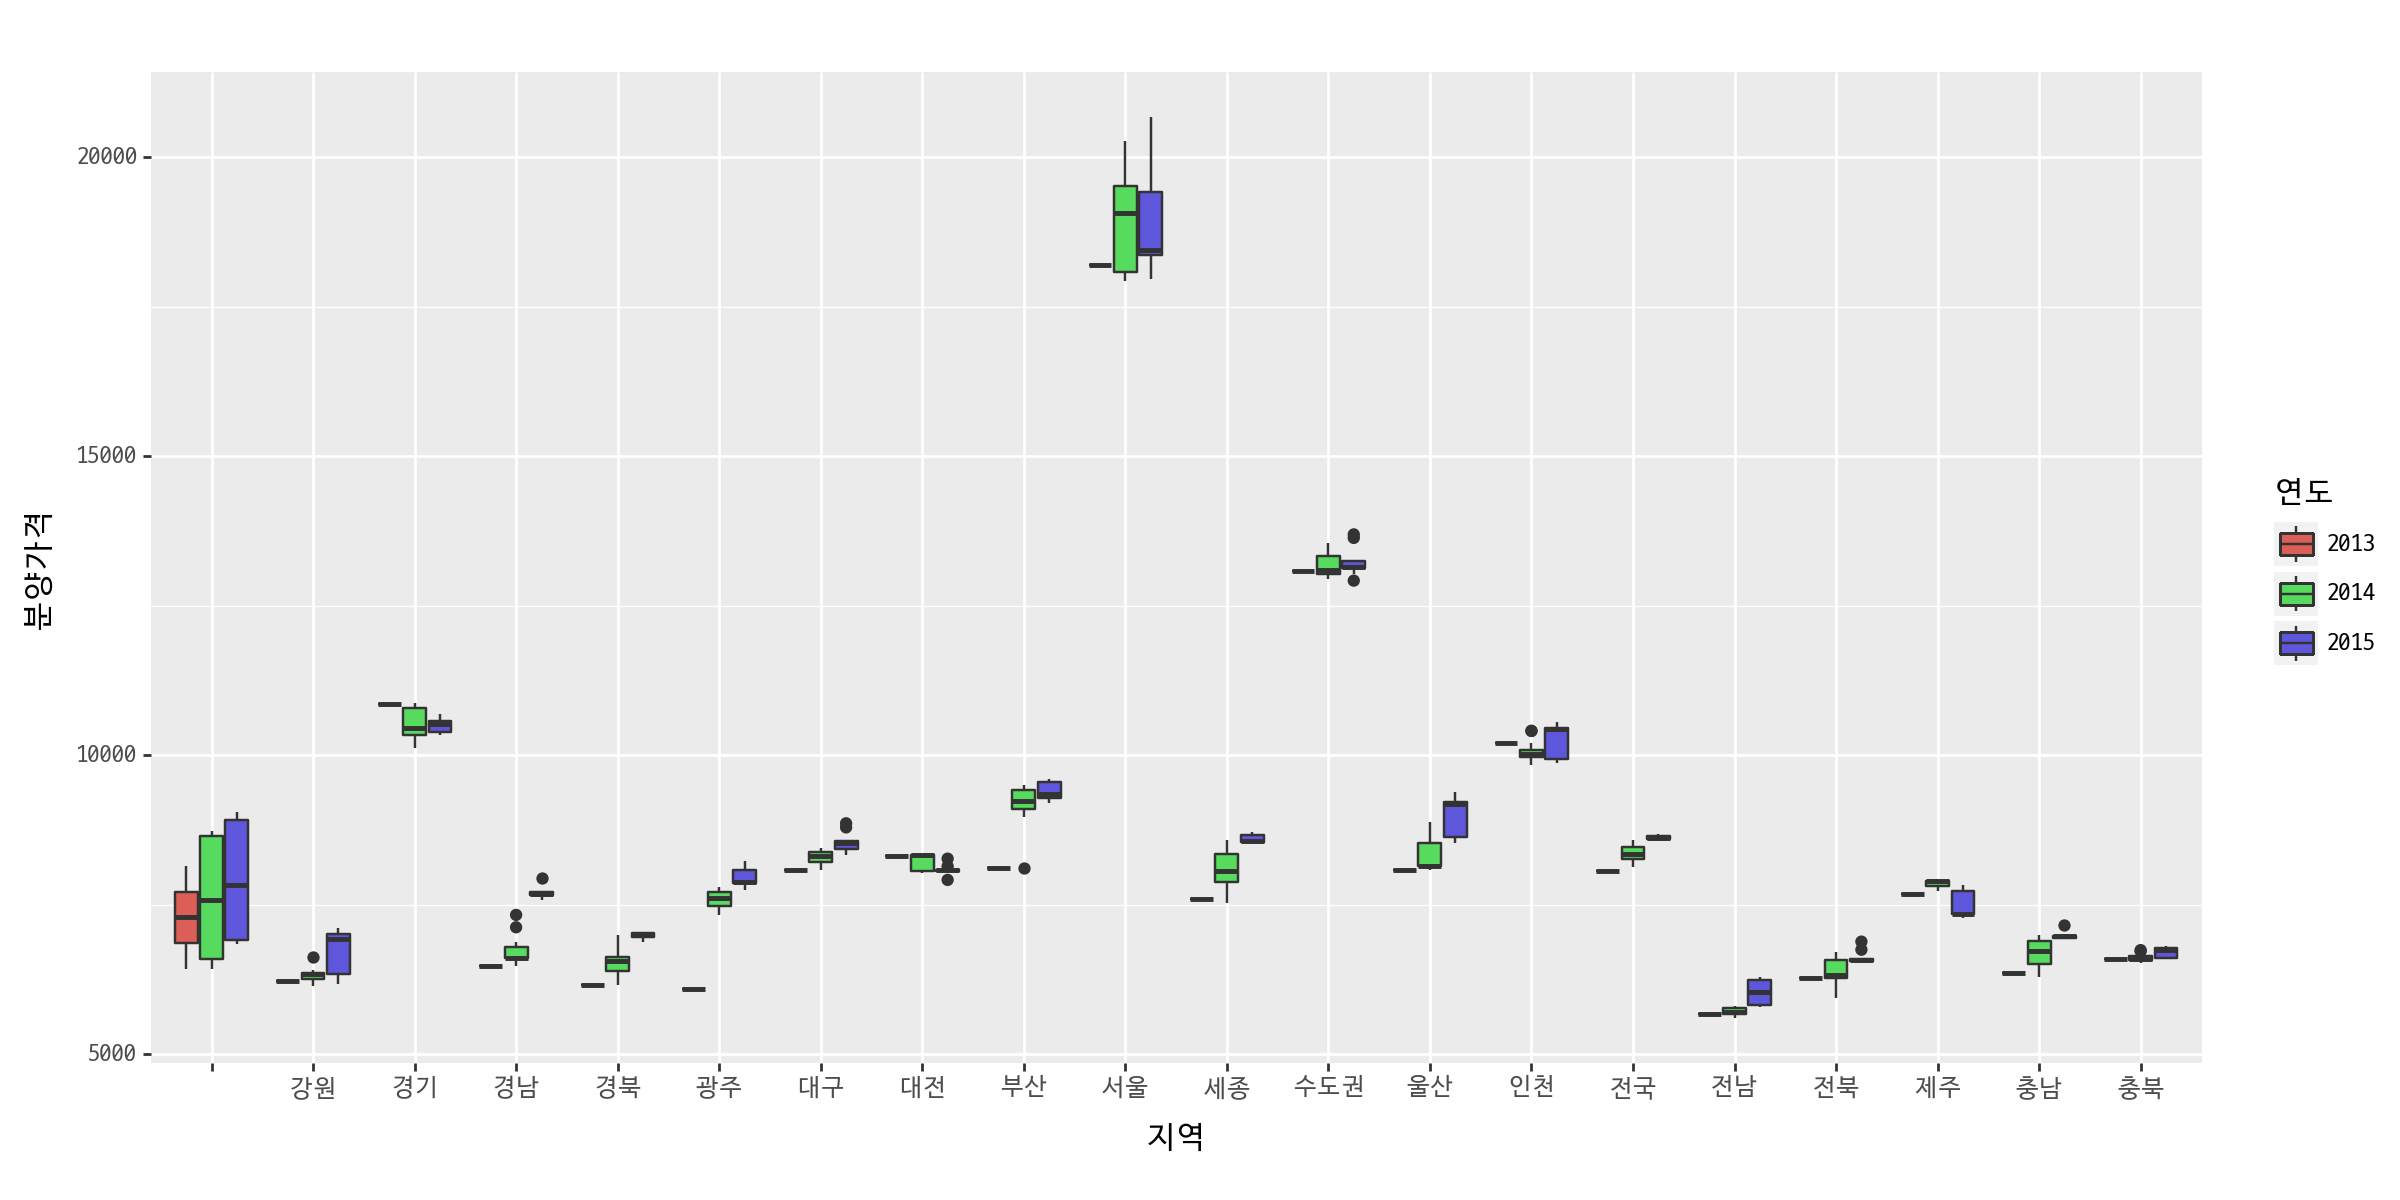

<Figure Size: (1200 x 600)>

In [163]:
# 실습01. 2013.12~2015.3월까지의 데이터시각화(box_plot)
(ggplot(df_2013_2015, aes(x='지역', y='분양가격', fill='연도'))
 + geom_boxplot()
 + theme(text=element_text(family='D2Coding'), figure_size=(12,6))
)

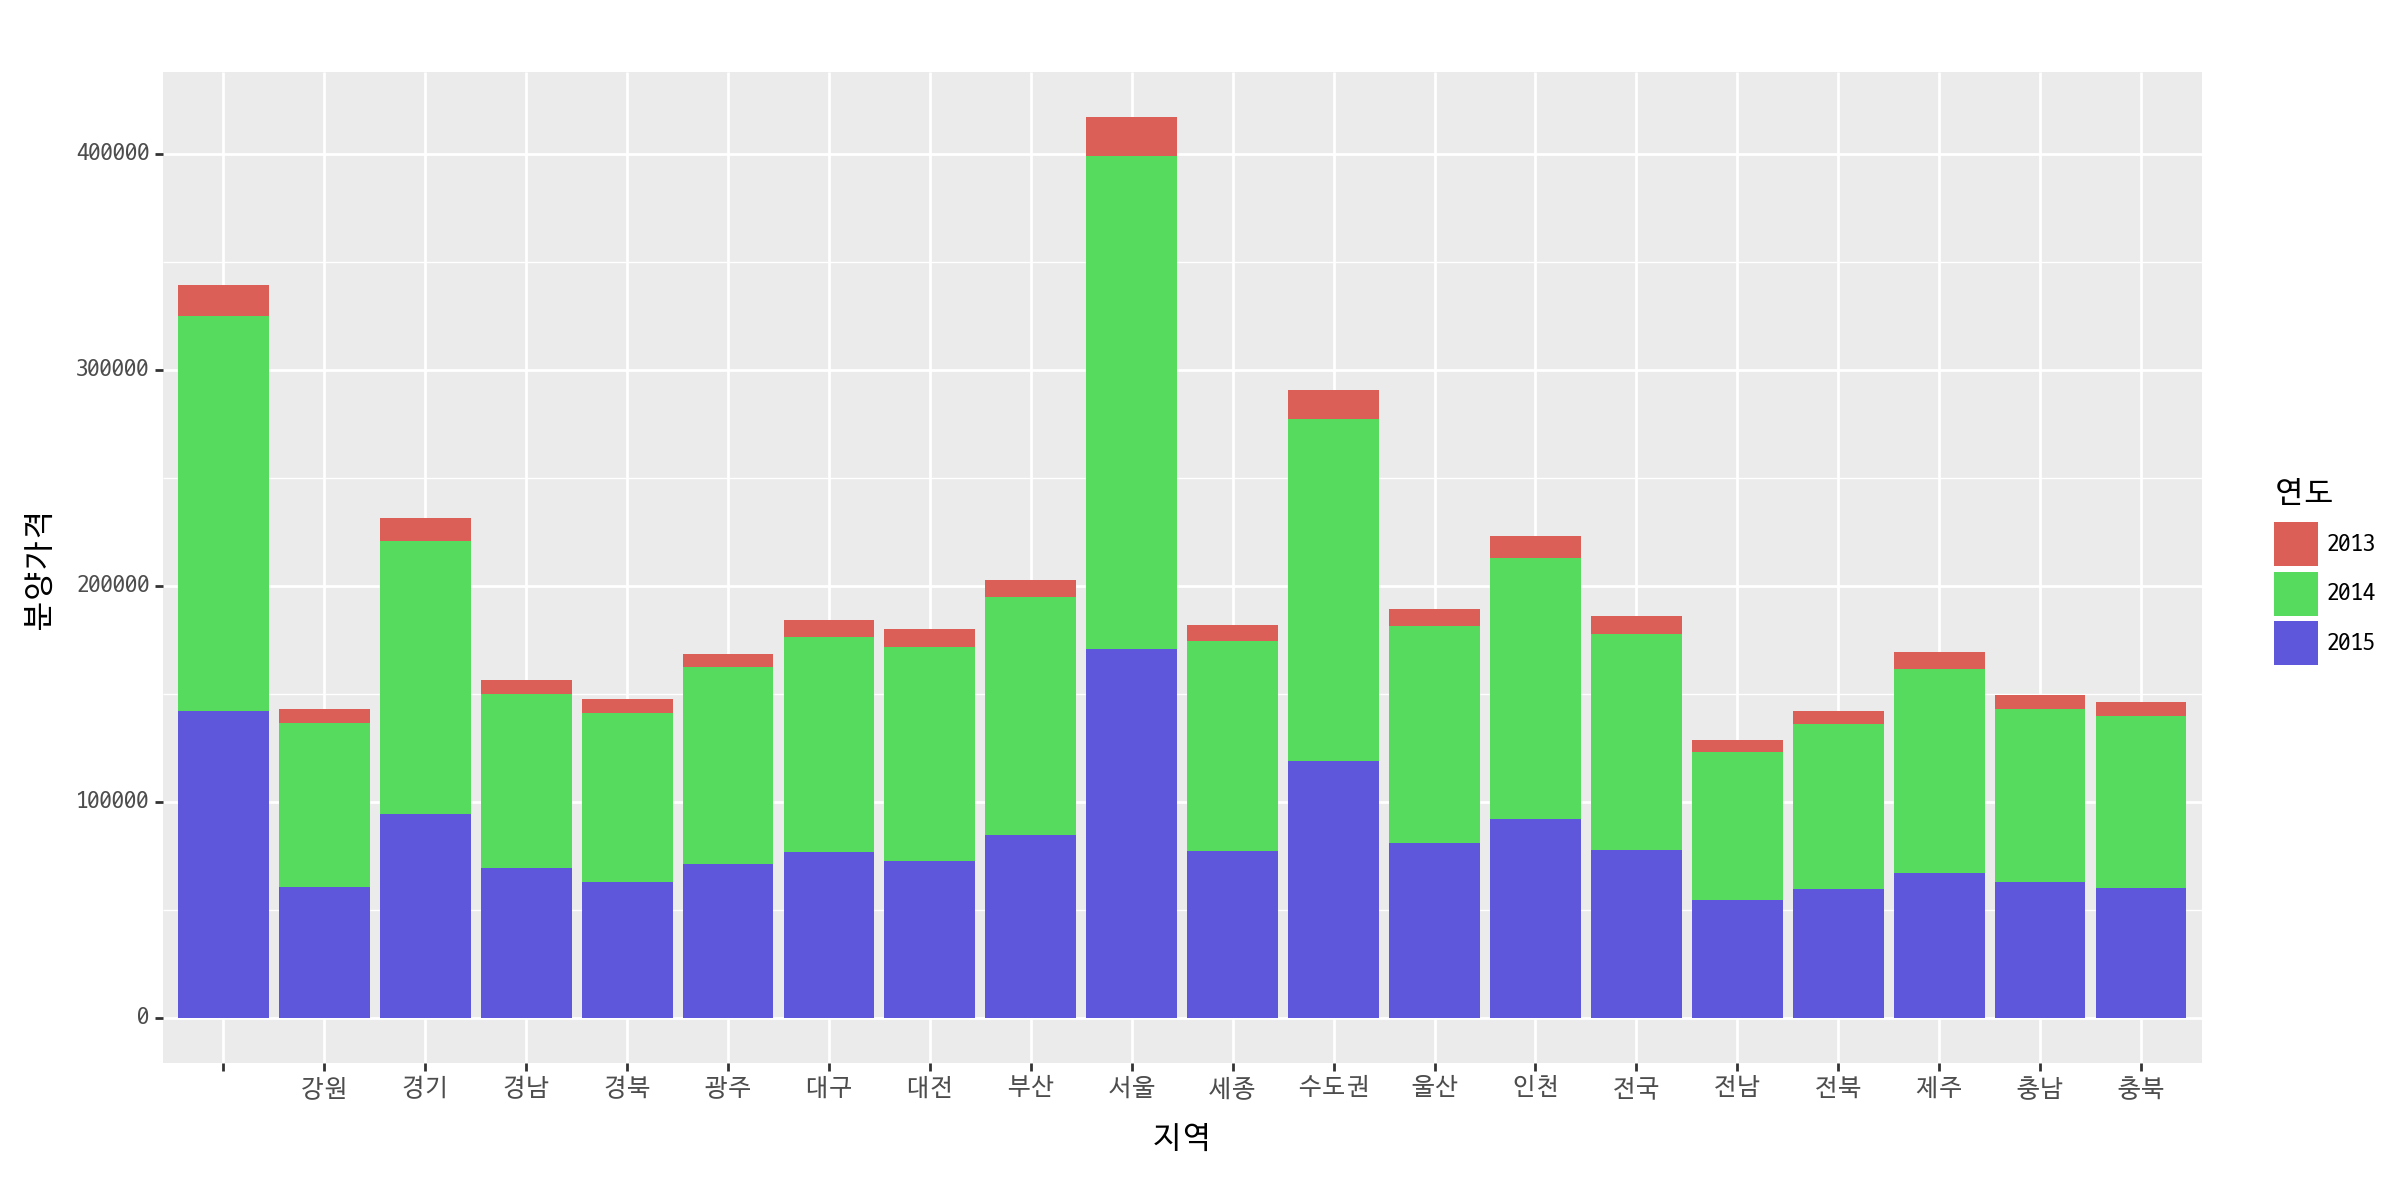

<Figure Size: (1200 x 600)>

In [164]:
# 실습02. 지역별/년도별 분양가격 (bar그래프)
(ggplot(df_2013_2015, aes(x='지역', y='분양가격', fill='연도'))
 + geom_bar(stat='identity')
 + theme(text=element_text(family='D2Coding'), figure_size=(12,6))
)

In [167]:
# 실습03. 2013~2020.3월까지 데이터 합치기
df_2013_2020 = pre_sale.loc[pre_sale.규모구분 == '전체']
print(df_2013_2020.shape)
display(df_2013_2020.head())


(918, 7)


,지역명,규모구분,연도,월,분양가격(㎡),분양가격,평당분양가격
0,서울,전체,2015,10,5841,"5,841.00","1,770.00"
5,인천,전체,2015,10,3163,"3,163.00",958.48
10,경기,전체,2015,10,3138,"3,138.00",950.91
15,부산,전체,2015,10,3112,"3,112.00",943.03
20,대구,전체,2015,10,2682,"2,682.00",812.73


Index(['지역명', '규모구분', '연도', '월', '분양가격(㎡)', '분양가격', '평당분양가격'], dtype='object')

In [168]:
display(df_2013_2020.columns)
display(df_2013_2015.columns)

Index(['지역명', '규모구분', '연도', '월', '분양가격(㎡)', '분양가격', '평당분양가격'], dtype='object')

Index(['지역', '기간', '분양가', '연도', '월', '분양가격'], dtype='object')

In [169]:
df_2013_2015_prepare = df_2013_2015[['지역','연도', '월', '분양가격']]
df_2013_2015_prepare.head()

,지역,연도,월,분양가격
0,전국,2013,12,8059
1,서울,2013,12,18189
2,부산,2013,12,8111
3,대구,2013,12,8080
4,인천,2013,12,10204


In [170]:
df_2013_2015_prepare.columns = ['지역명','연도', '월', '분양가격']
display(df_2013_2020.columns)
display(df_2013_2015_prepare.columns)

Index(['지역명', '규모구분', '연도', '월', '분양가격(㎡)', '분양가격', '평당분양가격'], dtype='object')

Index(['지역명', '연도', '월', '분양가격'], dtype='object')

In [174]:
# 컬럼을 일치시키기
df_2013_2020_prepare = df_2013_2020[['지역명','연도', '월', '분양가격']]
display(df_2013_2015_prepare.columns, df_2013_2015_prepare.shape)
display(df_2013_2020_prepare.columns, df_2013_2020_prepare.shape)

Index(['지역명', '연도', '월', '분양가격'], dtype='object')

(462, 4)

Index(['지역명', '연도', '월', '분양가격'], dtype='object')

(918, 4)

In [175]:
# df합치기
df_2013_2020 = pd.concat([df_2013_2015_prepare, df_2013_2020_prepare])
display(df_2013_2020.columns, df_2013_2020.shape)

Index(['지역명', '연도', '월', '분양가격'], dtype='object')

(1380, 4)

In [182]:
df_2013_2015_region = df_2013_2015_prepare.지역명.unique()
df_2013_2020_region = df_2013_2020_prepare.지역명.unique()
display(df_2013_2015_region, df_2013_2015_region.size)
display(df_2013_2020_region, df_2013_2020_region.size)

array(['전국', '서울', '부산', '대구', '인천', '광주', '대전', '울산', '', '경기', '수도권',
       '세종', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주'], dtype=object)

20

array(['서울', '인천', '경기', '부산', '대구', '광주', '대전', '울산', '세종', '강원', '충북',
       '충남', '전북', '전남', '경북', '경남', '제주'], dtype=object)

17

In [185]:
exclude_region = [region \
                    for region in df_2013_2015_region \
                    if not region in df_2013_2020_region]
exclude_region

['전국', '', '수도권']

In [186]:
df_2013_2020.loc[df_2013_2020.지역명.str.match('전국|수도권')].head()

,지역명,연도,월,분양가격
0,전국,2013,12,"8,059.00"
10,수도권,2013,12,"13,083.00"
21,전국,2014,1,"8,130.00"
31,수도권,2014,1,"12,995.00"
42,전국,2014,2,"8,195.00"


In [194]:
# ['전국', '', '수도권']를 drop 시키기
df_2013_2020.drop(\
    df_2013_2020.loc[df_2013_2020.지역명.str.match('전국|수도권')].index
                  , axis=0, inplace=True)

df_2013_2020.drop(\
    df_2013_2020.loc[df_2013_2020.지역명 == ''].index
                  , axis=0, inplace=True)

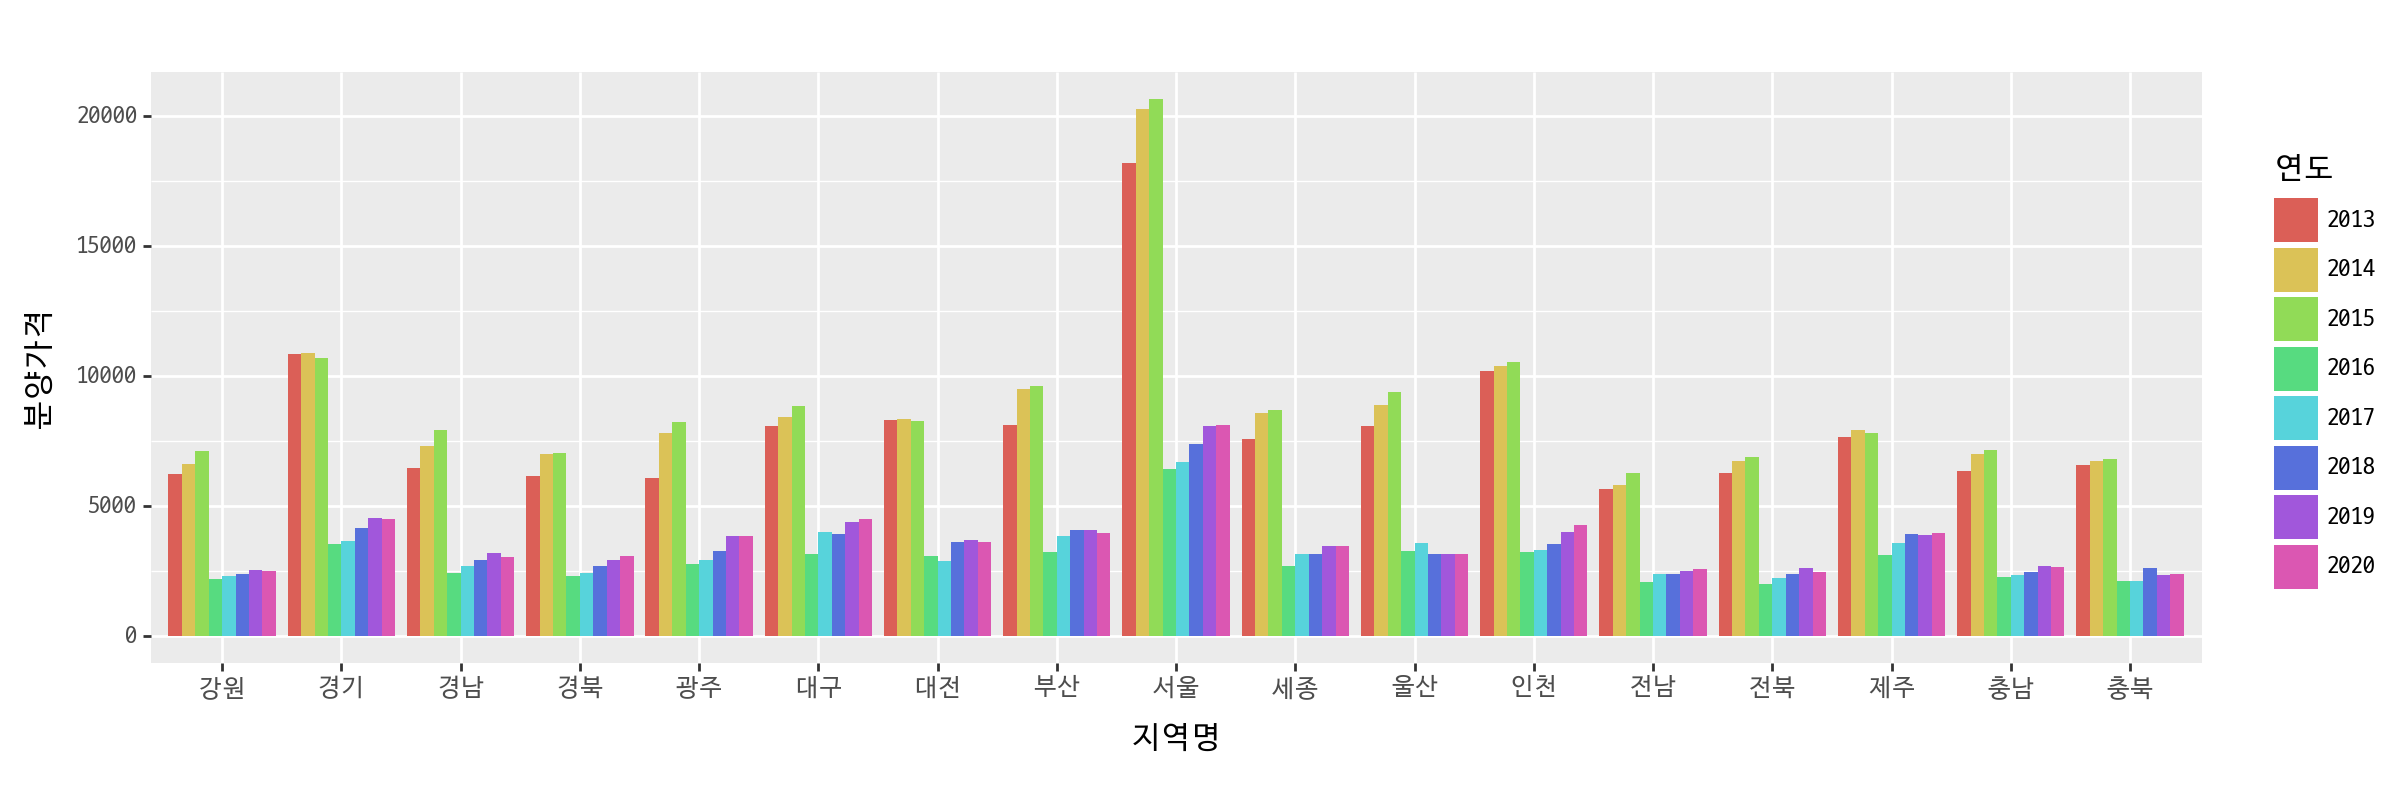

<Figure Size: (1200 x 400)>

In [195]:
# 실습. 2013~2020까지의 지역별 평당분양가격시각화
(ggplot(df_2013_2020)
 + aes(x='지역명', y='분양가격', fill='연도')
 + geom_bar(stat='identity', position='dodge')
 + theme(text=element_text(family='D2Coding'), figure_size=(12,4))
)

In [ ]:
# 실습. 2013~2020까지의 연도별 평당분양가격시각화
# geom_bar()

In [ ]:
# 실습. 2013~2020까지의 연도별 평당분양가격시각화
# geom_boxplot()

In [ ]:
# 실습. 2013~2020까지의 서울의 연도별 평당분양가격시각화
# geom_boxplot()

In [ ]:
# 실습. 2013~2020까지의 지역별/연도별 평당분양가격시각화
# geom_boxplot(), 지역명으로 행렬형태 시각화

##### 연습문제. data.go.kr에서 자유로 선정된 data를 선택
1. data를 다운 및 로딩
1. data 정제
1. 시각화